<a href="https://colab.research.google.com/github/cabroderick/ML-AM-MQP/blob/main/mask_rcnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Testing Mask-RCNN on sample dataset provided from ME team**

In [2]:
# fix package versions
!pip uninstall keras -y
!pip uninstall keras-nightly -y
!pip uninstall keras-Preprocessing -y
!pip uninstall keras-vis -y
!pip uninstall tensorflow -y
!pip uninstall h5py -y

Found existing installation: keras 2.7.0
Uninstalling keras-2.7.0:
  Successfully uninstalled keras-2.7.0
Found existing installation: Keras-Preprocessing 1.1.2
Uninstalling Keras-Preprocessing-1.1.2:
  Successfully uninstalled Keras-Preprocessing-1.1.2
Found existing installation: keras-vis 0.4.1
Uninstalling keras-vis-0.4.1:
  Successfully uninstalled keras-vis-0.4.1
Found existing installation: tensorflow 2.7.0
Uninstalling tensorflow-2.7.0:
  Successfully uninstalled tensorflow-2.7.0
Found existing installation: h5py 3.1.0
Uninstalling h5py-3.1.0:
  Successfully uninstalled h5py-3.1.0


In [1]:
!pip install tensorflow==1.13.1
!pip install tensorflow-gpu==1.13.1
!pip install keras==2.1.0
!pip install h5py==2.10.0

In [1]:
# import repo and set up maskrcnn
!git clone https://github.com/matterport/Mask_RCNN.git
%cd Mask_RCNN/
!python setup.py install
!pip show mask-rcnn

Cloning into 'Mask_RCNN'...
remote: Enumerating objects: 956, done.
remote: Total 956 (delta 0), reused 0 (delta 0), pack-reused 956
Receiving objects: 100% (956/956), 125.23 MiB | 25.25 MiB/s, done.
Resolving deltas: 100% (565/565), done.
/content/Mask_RCNN
/usr/local/lib/python3.7/dist-packages/setuptools/dist.py:700: UserWarning: Usage of dash-separated 'description-file' will not be supported in future versions. Please use the underscore name 'description_file' instead
  % (opt, underscore_opt))
/usr/local/lib/python3.7/dist-packages/setuptools/dist.py:700: UserWarning: Usage of dash-separated 'license-file' will not be supported in future versions. Please use the underscore name 'license_file' instead
  % (opt, underscore_opt))
/usr/local/lib/python3.7/dist-packages/setuptools/dist.py:700: UserWarning: Usage of dash-separated 'requirements-file' will not be supported in future versions. Please use the underscore name 'requirements_file' instead
  % (opt, underscore_opt))
running i

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# list data contents
%cd /content/drive/MyDrive/MQP/Trial/H6_subset
!ls . 
%cd '/content/drive/MyDrive/MQP/Trial/Labeled H6'
!ls .
%cd

/content/drive/MyDrive/MQP/Trial/H6_subset
A1H6COL_113.tif  A1H6COL_22.tif   A1H6COL_33.tif   A1H6COL_44.tif
A1H6COL_114.tif  A1H6COL_23.tif   A1H6COL_34.tif   A1H6COL_45.tif
A1H6COL_115.tif  A1H6COL_24.tif   A1H6COL_35.tif   A1H6COL_46.tif
A1H6COL_116.tif  A1H6COL_25.tif   A1H6COL_36.tif   A1H6COL_47.tif
A1H6COL_117.tif  A1H6COL_26.tif   A1H6COL_37.tif   A1H6COL_48.tif
A1H6COL_118.tif  A1H6COL_27.tif   A1H6COL_38.tif   A1H6COL_49.tif
A1H6COL_119.tif  A1H6COL_28.tif   A1H6COL_39.tif   A1H6COL_510.tif
A1H6COL_120.tif  A1H6COL_29.tif   A1H6COL_410.tif  A1H6COL_511.tif
A1H6COL_121.tif  A1H6COL_310.tif  A1H6COL_411.tif  A1H6COL_512.tif
A1H6COL_210.tif  A1H6COL_311.tif  A1H6COL_412.tif  A1H6COL_513.tif
A1H6COL_211.tif  A1H6COL_312.tif  A1H6COL_413.tif  A1H6COL_514.tif
A1H6COL_212.tif  A1H6COL_313.tif  A1H6COL_414.tif  A1H6COL_515.tif
A1H6COL_213.tif  A1H6COL_314.tif  A1H6COL_415.tif  A1H6COL_516.tif
A1H6COL_214.tif  A1H6COL_315.tif  A1H6COL_416.tif  A1H6COL_52.tif
A1H6COL_215.tif  A1H6COL_3

In [1]:
'''
Mask RCNN model training on custom AM dataset for train use on WPI HPC cluster
Usage: python train.py [model name] [optional pre-trained weights file path]
'''

import json
import os
import sys
import numpy as np
import cv2
from mrcnn import utils
from mrcnn.config import Config
from mrcnn.model import MaskRCNN

BORDER_WIDTH = 5

# if len(sys.argv) < 2: # ensure model name is included in arguments
  # sys.exit('Insufficient arguments')

######################################
# Configuration
######################################
class CustomConfig(Config):
    NAME = "custom_mcrnn"
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    NUM_CLASSES = 1 + 3 # 3 classes + background
    STEPS_PER_EPOCH = 100
    VALIDATION_STEPS = 5
    LEARNING_RATE = .001
    BATCH_SIZE = 1

config = CustomConfig()
# config.display()

#######################################
# Dataset
#######################################
class CustomDataset(utils.Dataset):

  # define constants
  BASE_IMAGES_DIR = '/content/drive/MyDrive/MQP/Trial/' # directory where all images can be found
  BASE_ANNOTATIONS_DIR = '/content/drive/MyDrive/MQP/Trial/' # directory where all images labels can be found
  IMAGES_DIRS = ['H6_subset/'] # list of directories where images are contained
  ANNOTATIONS_DIRS = ['Labeled H6/'] # corresponding list of directories where annotations are contained
  TRAIN_TEST_SPLIT = .8 # proportion of images to use for training set, remainder will be reserved for validation
  CLASSES = ['gas entrapment porosity', 'lack of fusion porosity', 'keyhole porosity'] # all annotation classes

  '''
  Loads the dataset
  validation: Indicates whether the current set is the validation set
  '''
  def load_dataset(self, validation=False):
    image_paths = []
    annotation_paths = []
    image_ids = []

    for i in range(len(self.IMAGES_DIRS)):
      i_dir = self.BASE_IMAGES_DIR + self.IMAGES_DIRS[i]
      a_dir = self.BASE_ANNOTATIONS_DIR + self.ANNOTATIONS_DIRS[i]
      for file in os.listdir(i_dir):
        i_id = file[:-4]
        image_ids.append(i_id)
        image_paths.append(i_dir+i_id+'.tif')
        annotation_paths.append(a_dir+i_id+'_20X_YZ.json')
    
    if (len(image_paths) != len(annotation_paths)): # raise exception if mismatch betwaeen number of images and annotations
      raise(ValueError('Number of images and annotations must be equal'))

    total_images = len(image_paths) # count of all images to be processed
    val_images = (int) (total_images * (1-self.TRAIN_TEST_SPLIT)) # the total number of images in the validation set

    # configure dataset
    for i in range(len(self.CLASSES)):
      self.add_class('dataset', i+1, self.CLASSES[i]) # add classes to model

    val_images_counter = val_images # counter to keep track of remaining images for validation set

    for i in range(total_images):
      if validation and val_images_counter > 0:
        val_images_counter -=1
        continue
      if (not validation) and val_images_counter < total_images:
        val_images_counter += 1
        continue

      image_id = image_ids[i]
      image_path = image_paths[i]
      annotation_path = annotation_paths[i]
      # print(image_id, image_path, annotation_path)

      mask, class_ids = self.extract_mask(image_path, annotation_path)

      self.add_image('dataset',
                     image_id=image_id, 
                     path=image_path,
                     mask=mask,
                     class_ids=class_ids)

  '''
  Extracts a mask from an image
  image_id: The image id to extract the mask from
  Returns a mask and a corresponding list of class ids
  '''
  def load_mask(self, image_id):

    info = self.image_info[image_id] # extract image info from data added earlier
    mask = info['mask']
    class_ids = info['class_ids']

    return mask, class_ids

  '''
  Extracts the mask data from an image and its respective annotation
  image_path: Path to the image
  annotation_path: Path to the annotation
  Returns a mask and a list of class ids
  '''
  def extract_mask(self, image_path, annotation_path):
    class_ids = []
    f_ann = open(annotation_path,)
    annotation_json = json.load(f_ann)
    image = cv2.imread(image_path)
    height = image.shape[0]
    width = image.shape[1]

    annotation_list = []
    [annotation_list.append(shape) for shape in annotation_json['shapes'] if shape['shape_type'] =='rectangle'] # get annotations in a list
    mask = np.zeros([height, width, len(annotation_list)], dtype='uint8') # initialize array of masks for each bounding box

    for i in range(len(annotation_list)):
      a = annotation_list[i]
      # extract row and col data and crop image to annotation size
      col_min, col_max = int(min(a['points'][0][0], a['points'][1][0])), int(max(a['points'][0][0], a['points'][1][0]))
      row_min, row_max = int(min(a['points'][0][1], a['points'][1][1])), int(max(a['points'][0][1], a['points'][1][1]))
      cropped_img = image[row_min:row_max, col_min:col_max]  # crop image to size of bounding box
      cropped_img_gray = cv2.cvtColor(cropped_img, cv2.COLOR_BGR2GRAY)
      edged = cv2.Canny(cropped_img_gray, 30, 200)
      # border = cv2.copyMakeBorder(edged, BORDER_WIDTH, BORDER_WIDTH,BORDER_WIDTH,BORDER_WIDTH, cv2.BORDER_CONSTANT,
                                      # value=[0, 0, 0])

      # apply contour to image and fill
      kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (2, 2))
      # dilated = cv2.dilate(border, kernel)
      dilated = cv2.dilate(edged, kernel)
      contours, hierarchy = cv2.findContours(dilated.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
      # polygon = np.zeros(border.shape)
      polygon = np.zeros(cropped_img.shape)
      color = [255, 255, 255]
      cv2.fillPoly(polygon, contours, color)

      # normalize polygon to all boolean values and insert into mask
      # polygon_bool = np.alltrue(polygon == color)
      # mask[row_min+BORDER_WIDTH:row_max-BORDER_WIDTH, col_min+BORDER_WIDTH:col_max-BORDER_WIDTH, i] = polygon_bool
      polygon_bool = np.alltrue(polygon == color, axis=2)
      # mask[row_min+BORDER_WIDTH:row_max-BORDER_WIDTH, col_min+BORDER_WIDTH:col_max-BORDER_WIDTH, i] = polygon_bool
      mask[row_min:row_max, col_min:col_max, i] = polygon_bool

      # draw contour and mask
      # cv2.drawContours(border, contours, -1, (0, 255, 0), 1)
      # imS = cv2.resize(border, (512, 512))
      # cv2.imshow('Contours', imS)
      # cv2.waitKey(0)
      # cv2.imshow('Polygon', cv2.resize(polygon, (512, 512)))
      # cv2.waitKey(0)

      # extract class id and append to list
      class_label = self.normalize_classname(a['label'])
      class_id = self.CLASSES.index(class_label)
      class_ids.append(class_id)

    return mask.astype(np.bool), np.array(class_ids, dtype=np.int32)

  def normalize_classname(self, class_name): # normalize the class name to one used by the model
    class_name = class_name.lower() # remove capitalization
    classes_dict = { # dictionary containing all class names used in labels and their appropriate model class name
      'gas entrapment porosity' : 'gas entrapment porosity',
      'keyhole porosity' : 'keyhole porosity',
      'lack of fusion porosity' : 'lack of fusion porosity',
      'fusion porosity' : 'lack of fusion porosity',
      'gas porosity' : 'gas entrapment porosity'
    }
    return classes_dict.get(class_name)

#######################################
# Training
#######################################

# set up train and validation data

dataset_train = CustomDataset()
dataset_train.load_dataset(validation=False)
dataset_train.prepare()

dataset_val = CustomDataset()
dataset_val.load_dataset(validation=True)
dataset_val.prepare()

# configure model

model = MaskRCNN(mode='training', model_dir='./'+sys.argv[1]+'/', config=CustomConfig())

# if len(sys.argv) > 2: # optionally load pre-trained weights
#   model.load_weights(sys.argv[2], by_name=True, exclude=["mrcnn_class_logits", "mrcnn_bbox_fc",  "mrcnn_bbox", "mrcnn_mask"])
# print summary
model.load_weights('/content/drive/MyDrive/MQP/mask_rcnn_coco.h5', by_name=True, exclude=["mrcnn_class_logits", "mrcnn_bbox_fc",  "mrcnn_bbox", "mrcnn_mask"])
# print(model.keras_model.summary())

# train model
model.train(train_dataset=dataset_train,
           val_dataset=dataset_val,
           learning_rate=config.LEARNING_RATE,
           epochs=5,
           layers='heads')

# save training results to external file
model.keras_model.save_weights('custom_mrcnn_coco.h5')

/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:529: FutureWarning: Passing (type, 1) or 

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead

Starting at epoch 0. LR=0.001

Checkpoint Path: ./-f/custom_mcrnn20211208T1457/mask_rcnn_custom_mcrnn_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_m

/usr/local/lib/python3.7/dist-packages/tensorflow/python/ops/gradients_impl.py:110: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2039: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


Epoch 1/5


/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

  1/100 [..............................] - ETA: 51:25 - loss: 9.1287 - rpn_class_loss: 3.7123 - rpn_bbox_loss: 1.9656 - mrcnn_class_loss: 0.5840 - mrcnn_bbox_loss: 2.1361 - mrcnn_mask_loss: 0.7308

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  2/100 [..............................] - ETA: 26:32 - loss: 7.8711 - rpn_class_loss: 3.1828 - rpn_bbox_loss: 1.7667 - mrcnn_class_loss: 0.6289 - mrcnn_bbox_loss: 1.6694 - mrcnn_mask_loss: 0.6233

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

  3/100 [..............................] - ETA: 18:17 - loss: 7.8526 - rpn_class_loss: 3.1789 - rpn_bbox_loss: 1.8873 - mrcnn_class_loss: 0.4733 - mrcnn_bbox_loss: 1.6714 - mrcnn_mask_loss: 0.6416

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

  4/100 [>.............................] - ETA: 14:06 - loss: 7.4637 - rpn_class_loss: 3.0060 - rpn_bbox_loss: 1.8904 - mrcnn_class_loss: 0.3787 - mrcnn_bbox_loss: 1.5386 - mrcnn_mask_loss: 0.6501

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

  5/100 [>.............................] - ETA: 11:36 - loss: 7.0060 - rpn_class_loss: 2.8126 - rpn_bbox_loss: 1.8211 - mrcnn_class_loss: 0.3430 - mrcnn_bbox_loss: 1.4057 - mrcnn_mask_loss: 0.6235

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  6/100 [>.............................] - ETA: 9:55 - loss: 6.5830 - rpn_class_loss: 2.6641 - rpn_bbox_loss: 1.7608 - mrcnn_class_loss: 0.2917 - mrcnn_bbox_loss: 1.2519 - mrcnn_mask_loss: 0.6145 

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  7/100 [=>............................] - ETA: 8:42 - loss: 6.4317 - rpn_class_loss: 2.4904 - rpn_bbox_loss: 1.7402 - mrcnn_class_loss: 0.2850 - mrcnn_bbox_loss: 1.2338 - mrcnn_mask_loss: 0.6822

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

  8/100 [=>............................] - ETA: 7:47 - loss: 6.1692 - rpn_class_loss: 2.2630 - rpn_bbox_loss: 1.7602 - mrcnn_class_loss: 0.2608 - mrcnn_bbox_loss: 1.2154 - mrcnn_mask_loss: 0.6697

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  9/100 [=>............................] - ETA: 7:05 - loss: 5.8377 - rpn_class_loss: 2.0546 - rpn_bbox_loss: 1.7022 - mrcnn_class_loss: 0.2374 - mrcnn_bbox_loss: 1.1917 - mrcnn_mask_loss: 0.6518

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 10/100 [==>...........................] - ETA: 6:30 - loss: 5.9252 - rpn_class_loss: 1.8805 - rpn_bbox_loss: 1.6504 - mrcnn_class_loss: 0.2198 - mrcnn_bbox_loss: 1.2260 - mrcnn_mask_loss: 0.9484

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 11/100 [==>...........................] - ETA: 6:02 - loss: 5.6954 - rpn_class_loss: 1.7394 - rpn_bbox_loss: 1.5960 - mrcnn_class_loss: 0.2054 - mrcnn_bbox_loss: 1.2451 - mrcnn_mask_loss: 0.9096

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 12/100 [==>...........................] - ETA: 5:37 - loss: 5.4690 - rpn_class_loss: 1.6382 - rpn_bbox_loss: 1.5289 - mrcnn_class_loss: 0.1912 - mrcnn_bbox_loss: 1.2360 - mrcnn_mask_loss: 0.8747

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 13/100 [==>...........................] - ETA: 5:17 - loss: 5.3868 - rpn_class_loss: 1.5734 - rpn_bbox_loss: 1.5011 - mrcnn_class_loss: 0.1842 - mrcnn_bbox_loss: 1.1879 - mrcnn_mask_loss: 0.9402

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 14/100 [===>..........................] - ETA: 4:59 - loss: 5.2507 - rpn_class_loss: 1.5241 - rpn_bbox_loss: 1.4591 - mrcnn_class_loss: 0.1804 - mrcnn_bbox_loss: 1.1419 - mrcnn_mask_loss: 0.9454

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 15/100 [===>..........................] - ETA: 4:43 - loss: 5.1989 - rpn_class_loss: 1.4860 - rpn_bbox_loss: 1.4214 - mrcnn_class_loss: 0.1707 - mrcnn_bbox_loss: 1.0985 - mrcnn_mask_loss: 1.0224

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 16/100 [===>..........................] - ETA: 4:30 - loss: 5.1113 - rpn_class_loss: 1.4481 - rpn_bbox_loss: 1.4093 - mrcnn_class_loss: 0.1632 - mrcnn_bbox_loss: 1.0804 - mrcnn_mask_loss: 1.0103

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 17/100 [====>.........................] - ETA: 4:17 - loss: 5.0158 - rpn_class_loss: 1.4087 - rpn_bbox_loss: 1.3960 - mrcnn_class_loss: 0.1562 - mrcnn_bbox_loss: 1.0542 - mrcnn_mask_loss: 1.0007

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 18/100 [====>.........................] - ETA: 4:06 - loss: 4.9421 - rpn_class_loss: 1.3749 - rpn_bbox_loss: 1.3792 - mrcnn_class_loss: 0.1538 - mrcnn_bbox_loss: 1.0460 - mrcnn_mask_loss: 0.9882

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 19/100 [====>.........................] - ETA: 3:56 - loss: 4.8457 - rpn_class_loss: 1.3415 - rpn_bbox_loss: 1.3659 - mrcnn_class_loss: 0.1463 - mrcnn_bbox_loss: 1.0231 - mrcnn_mask_loss: 0.9689

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 20/100 [=====>........................] - ETA: 3:46 - loss: 4.7950 - rpn_class_loss: 1.3088 - rpn_bbox_loss: 1.3489 - mrcnn_class_loss: 0.1398 - mrcnn_bbox_loss: 1.0436 - mrcnn_mask_loss: 0.9538

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 21/100 [=====>........................] - ETA: 3:38 - loss: 4.7215 - rpn_class_loss: 1.2702 - rpn_bbox_loss: 1.3256 - mrcnn_class_loss: 0.1344 - mrcnn_bbox_loss: 1.0299 - mrcnn_mask_loss: 0.9613

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 22/100 [=====>........................] - ETA: 3:30 - loss: 4.6325 - rpn_class_loss: 1.2286 - rpn_bbox_loss: 1.3268 - mrcnn_class_loss: 0.1284 - mrcnn_bbox_loss: 1.0036 - mrcnn_mask_loss: 0.9450

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 23/100 [=====>........................] - ETA: 3:23 - loss: 4.5458 - rpn_class_loss: 1.1921 - rpn_bbox_loss: 1.3209 - mrcnn_class_loss: 0.1231 - mrcnn_bbox_loss: 0.9791 - mrcnn_mask_loss: 0.9306

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 24/100 [======>.......................] - ETA: 3:16 - loss: 4.4376 - rpn_class_loss: 1.1503 - rpn_bbox_loss: 1.3035 - mrcnn_class_loss: 0.1186 - mrcnn_bbox_loss: 0.9508 - mrcnn_mask_loss: 0.9144

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 25/100 [======>.......................] - ETA: 3:10 - loss: 4.3382 - rpn_class_loss: 1.1114 - rpn_bbox_loss: 1.2808 - mrcnn_class_loss: 0.1149 - mrcnn_bbox_loss: 0.9323 - mrcnn_mask_loss: 0.8988

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 26/100 [======>.......................] - ETA: 3:04 - loss: 4.2096 - rpn_class_loss: 1.0745 - rpn_bbox_loss: 1.2639 - mrcnn_class_loss: 0.1105 - mrcnn_bbox_loss: 0.8964 - mrcnn_mask_loss: 0.8642

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 27/100 [=======>......................] - ETA: 2:58 - loss: 4.1705 - rpn_class_loss: 1.0435 - rpn_bbox_loss: 1.2552 - mrcnn_class_loss: 0.1066 - mrcnn_bbox_loss: 0.9098 - mrcnn_mask_loss: 0.8555

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 28/100 [=======>......................] - ETA: 2:53 - loss: 4.1017 - rpn_class_loss: 1.0129 - rpn_bbox_loss: 1.2383 - mrcnn_class_loss: 0.1055 - mrcnn_bbox_loss: 0.8885 - mrcnn_mask_loss: 0.8565

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 29/100 [=======>......................] - ETA: 2:48 - loss: 4.0574 - rpn_class_loss: 0.9886 - rpn_bbox_loss: 1.2228 - mrcnn_class_loss: 0.1052 - mrcnn_bbox_loss: 0.8908 - mrcnn_mask_loss: 0.8500

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 30/100 [========>.....................] - ETA: 2:43 - loss: 4.0093 - rpn_class_loss: 0.9607 - rpn_bbox_loss: 1.2084 - mrcnn_class_loss: 0.1051 - mrcnn_bbox_loss: 0.8895 - mrcnn_mask_loss: 0.8457

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 31/100 [========>.....................] - ETA: 2:38 - loss: 3.9645 - rpn_class_loss: 0.9372 - rpn_bbox_loss: 1.1983 - mrcnn_class_loss: 0.1032 - mrcnn_bbox_loss: 0.8924 - mrcnn_mask_loss: 0.8334

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 32/100 [========>.....................] - ETA: 2:34 - loss: 3.9401 - rpn_class_loss: 0.9313 - rpn_bbox_loss: 1.1964 - mrcnn_class_loss: 0.1040 - mrcnn_bbox_loss: 0.8811 - mrcnn_mask_loss: 0.8273

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 33/100 [========>.....................] - ETA: 2:30 - loss: 3.8854 - rpn_class_loss: 0.9061 - rpn_bbox_loss: 1.1890 - mrcnn_class_loss: 0.1029 - mrcnn_bbox_loss: 0.8622 - mrcnn_mask_loss: 0.8252

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 34/100 [=========>....................] - ETA: 2:26 - loss: 3.8319 - rpn_class_loss: 0.8826 - rpn_bbox_loss: 1.1766 - mrcnn_class_loss: 0.1044 - mrcnn_bbox_loss: 0.8534 - mrcnn_mask_loss: 0.8149

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 35/100 [=========>....................] - ETA: 2:22 - loss: 3.8039 - rpn_class_loss: 0.8701 - rpn_bbox_loss: 1.1742 - mrcnn_class_loss: 0.1038 - mrcnn_bbox_loss: 0.8466 - mrcnn_mask_loss: 0.8092

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 36/100 [=========>....................] - ETA: 2:18 - loss: 3.7788 - rpn_class_loss: 0.8577 - rpn_bbox_loss: 1.1760 - mrcnn_class_loss: 0.1025 - mrcnn_bbox_loss: 0.8399 - mrcnn_mask_loss: 0.8027

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 37/100 [==========>...................] - ETA: 2:15 - loss: 3.7461 - rpn_class_loss: 0.8423 - rpn_bbox_loss: 1.1822 - mrcnn_class_loss: 0.1001 - mrcnn_bbox_loss: 0.8268 - mrcnn_mask_loss: 0.7947

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 38/100 [==========>...................] - ETA: 2:11 - loss: 3.7047 - rpn_class_loss: 0.8219 - rpn_bbox_loss: 1.1766 - mrcnn_class_loss: 0.0980 - mrcnn_bbox_loss: 0.8168 - mrcnn_mask_loss: 0.7914

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 39/100 [==========>...................] - ETA: 2:08 - loss: 3.6732 - rpn_class_loss: 0.8047 - rpn_bbox_loss: 1.1697 - mrcnn_class_loss: 0.0955 - mrcnn_bbox_loss: 0.8168 - mrcnn_mask_loss: 0.7865

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

 40/100 [===========>..................] - ETA: 2:05 - loss: 3.6313 - rpn_class_loss: 0.7874 - rpn_bbox_loss: 1.1687 - mrcnn_class_loss: 0.0936 - mrcnn_bbox_loss: 0.8042 - mrcnn_mask_loss: 0.7775

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 41/100 [===========>..................] - ETA: 2:02 - loss: 3.6122 - rpn_class_loss: 0.7716 - rpn_bbox_loss: 1.1618 - mrcnn_class_loss: 0.0915 - mrcnn_bbox_loss: 0.8121 - mrcnn_mask_loss: 0.7752

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 42/100 [===========>..................] - ETA: 1:58 - loss: 3.5568 - rpn_class_loss: 0.7576 - rpn_bbox_loss: 1.1604 - mrcnn_class_loss: 0.0893 - mrcnn_bbox_loss: 0.7927 - mrcnn_mask_loss: 0.7567

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 43/100 [===========>..................] - ETA: 1:55 - loss: 3.5310 - rpn_class_loss: 0.7437 - rpn_bbox_loss: 1.1550 - mrcnn_class_loss: 0.0883 - mrcnn_bbox_loss: 0.7900 - mrcnn_mask_loss: 0.7541

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 44/100 [============>.................] - ETA: 1:52 - loss: 3.5044 - rpn_class_loss: 0.7284 - rpn_bbox_loss: 1.1471 - mrcnn_class_loss: 0.0866 - mrcnn_bbox_loss: 0.7919 - mrcnn_mask_loss: 0.7505

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 45/100 [============>.................] - ETA: 1:49 - loss: 3.4757 - rpn_class_loss: 0.7165 - rpn_bbox_loss: 1.1366 - mrcnn_class_loss: 0.0852 - mrcnn_bbox_loss: 0.7913 - mrcnn_mask_loss: 0.7462

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 46/100 [============>.................] - ETA: 1:47 - loss: 3.4422 - rpn_class_loss: 0.7033 - rpn_bbox_loss: 1.1292 - mrcnn_class_loss: 0.0844 - mrcnn_bbox_loss: 0.7805 - mrcnn_mask_loss: 0.7448

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 47/100 [=============>................] - ETA: 1:44 - loss: 3.4199 - rpn_class_loss: 0.6923 - rpn_bbox_loss: 1.1288 - mrcnn_class_loss: 0.0838 - mrcnn_bbox_loss: 0.7723 - mrcnn_mask_loss: 0.7427

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 48/100 [=============>................] - ETA: 1:41 - loss: 3.3907 - rpn_class_loss: 0.6802 - rpn_bbox_loss: 1.1211 - mrcnn_class_loss: 0.0826 - mrcnn_bbox_loss: 0.7659 - mrcnn_mask_loss: 0.7409

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 49/100 [=============>................] - ETA: 1:38 - loss: 3.3582 - rpn_class_loss: 0.6683 - rpn_bbox_loss: 1.1125 - mrcnn_class_loss: 0.0828 - mrcnn_bbox_loss: 0.7600 - mrcnn_mask_loss: 0.7346

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 50/100 [==============>...............] - ETA: 1:36 - loss: 3.3336 - rpn_class_loss: 0.6573 - rpn_bbox_loss: 1.1106 - mrcnn_class_loss: 0.0816 - mrcnn_bbox_loss: 0.7525 - mrcnn_mask_loss: 0.7316

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 51/100 [==============>...............] - ETA: 1:33 - loss: 3.3121 - rpn_class_loss: 0.6477 - rpn_bbox_loss: 1.1099 - mrcnn_class_loss: 0.0803 - mrcnn_bbox_loss: 0.7451 - mrcnn_mask_loss: 0.7291

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 52/100 [==============>...............] - ETA: 1:31 - loss: 3.2871 - rpn_class_loss: 0.6384 - rpn_bbox_loss: 1.1099 - mrcnn_class_loss: 0.0791 - mrcnn_bbox_loss: 0.7347 - mrcnn_mask_loss: 0.7250

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 53/100 [==============>...............] - ETA: 1:28 - loss: 3.2593 - rpn_class_loss: 0.6274 - rpn_bbox_loss: 1.1057 - mrcnn_class_loss: 0.0785 - mrcnn_bbox_loss: 0.7276 - mrcnn_mask_loss: 0.7201

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 54/100 [===============>..............] - ETA: 1:26 - loss: 3.2345 - rpn_class_loss: 0.6181 - rpn_bbox_loss: 1.0993 - mrcnn_class_loss: 0.0790 - mrcnn_bbox_loss: 0.7216 - mrcnn_mask_loss: 0.7165

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 55/100 [===============>..............] - ETA: 1:23 - loss: 3.2083 - rpn_class_loss: 0.6090 - rpn_bbox_loss: 1.0901 - mrcnn_class_loss: 0.0785 - mrcnn_bbox_loss: 0.7161 - mrcnn_mask_loss: 0.7145

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 56/100 [===============>..............] - ETA: 1:21 - loss: 3.1856 - rpn_class_loss: 0.6010 - rpn_bbox_loss: 1.0836 - mrcnn_class_loss: 0.0779 - mrcnn_bbox_loss: 0.7107 - mrcnn_mask_loss: 0.7124

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 57/100 [================>.............] - ETA: 1:19 - loss: 3.1675 - rpn_class_loss: 0.5924 - rpn_bbox_loss: 1.0796 - mrcnn_class_loss: 0.0771 - mrcnn_bbox_loss: 0.7078 - mrcnn_mask_loss: 0.7106

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 58/100 [================>.............] - ETA: 1:17 - loss: 3.1428 - rpn_class_loss: 0.5841 - rpn_bbox_loss: 1.0732 - mrcnn_class_loss: 0.0773 - mrcnn_bbox_loss: 0.6995 - mrcnn_mask_loss: 0.7086

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 59/100 [================>.............] - ETA: 1:14 - loss: 3.1196 - rpn_class_loss: 0.5761 - rpn_bbox_loss: 1.0691 - mrcnn_class_loss: 0.0770 - mrcnn_bbox_loss: 0.6927 - mrcnn_mask_loss: 0.7046

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 60/100 [=================>............] - ETA: 1:12 - loss: 3.0989 - rpn_class_loss: 0.5670 - rpn_bbox_loss: 1.0654 - mrcnn_class_loss: 0.0760 - mrcnn_bbox_loss: 0.6903 - mrcnn_mask_loss: 0.7001

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 61/100 [=================>............] - ETA: 1:10 - loss: 3.0728 - rpn_class_loss: 0.5598 - rpn_bbox_loss: 1.0594 - mrcnn_class_loss: 0.0751 - mrcnn_bbox_loss: 0.6813 - mrcnn_mask_loss: 0.6972

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 62/100 [=================>............] - ETA: 1:08 - loss: 3.0479 - rpn_class_loss: 0.5533 - rpn_bbox_loss: 1.0523 - mrcnn_class_loss: 0.0750 - mrcnn_bbox_loss: 0.6744 - mrcnn_mask_loss: 0.6928

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 63/100 [=================>............] - ETA: 1:06 - loss: 3.0319 - rpn_class_loss: 0.5463 - rpn_bbox_loss: 1.0485 - mrcnn_class_loss: 0.0740 - mrcnn_bbox_loss: 0.6728 - mrcnn_mask_loss: 0.6903

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 64/100 [==================>...........] - ETA: 1:04 - loss: 3.0111 - rpn_class_loss: 0.5390 - rpn_bbox_loss: 1.0451 - mrcnn_class_loss: 0.0735 - mrcnn_bbox_loss: 0.6657 - mrcnn_mask_loss: 0.6879

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 65/100 [==================>...........] - ETA: 1:02 - loss: 2.9978 - rpn_class_loss: 0.5320 - rpn_bbox_loss: 1.0418 - mrcnn_class_loss: 0.0724 - mrcnn_bbox_loss: 0.6665 - mrcnn_mask_loss: 0.6851

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 66/100 [==================>...........] - ETA: 1:00 - loss: 2.9849 - rpn_class_loss: 0.5259 - rpn_bbox_loss: 1.0413 - mrcnn_class_loss: 0.0718 - mrcnn_bbox_loss: 0.6639 - mrcnn_mask_loss: 0.6820

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 67/100 [===================>..........] - ETA: 58s - loss: 2.9609 - rpn_class_loss: 0.5188 - rpn_bbox_loss: 1.0335 - mrcnn_class_loss: 0.0710 - mrcnn_bbox_loss: 0.6582 - mrcnn_mask_loss: 0.6794 

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 68/100 [===================>..........] - ETA: 56s - loss: 2.9434 - rpn_class_loss: 0.5122 - rpn_bbox_loss: 1.0272 - mrcnn_class_loss: 0.0711 - mrcnn_bbox_loss: 0.6546 - mrcnn_mask_loss: 0.6782

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 69/100 [===================>..........] - ETA: 54s - loss: 2.9231 - rpn_class_loss: 0.5060 - rpn_bbox_loss: 1.0191 - mrcnn_class_loss: 0.0724 - mrcnn_bbox_loss: 0.6511 - mrcnn_mask_loss: 0.6744

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 70/100 [====================>.........] - ETA: 52s - loss: 2.9012 - rpn_class_loss: 0.4999 - rpn_bbox_loss: 1.0123 - mrcnn_class_loss: 0.0717 - mrcnn_bbox_loss: 0.6452 - mrcnn_mask_loss: 0.6721

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 71/100 [====================>.........] - ETA: 50s - loss: 2.8892 - rpn_class_loss: 0.4954 - rpn_bbox_loss: 1.0131 - mrcnn_class_loss: 0.0709 - mrcnn_bbox_loss: 0.6410 - mrcnn_mask_loss: 0.6688

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 72/100 [====================>.........] - ETA: 48s - loss: 2.8681 - rpn_class_loss: 0.4901 - rpn_bbox_loss: 1.0047 - mrcnn_class_loss: 0.0718 - mrcnn_bbox_loss: 0.6366 - mrcnn_mask_loss: 0.6648

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 73/100 [====================>.........] - ETA: 46s - loss: 2.8511 - rpn_class_loss: 0.4848 - rpn_bbox_loss: 1.0011 - mrcnn_class_loss: 0.0716 - mrcnn_bbox_loss: 0.6312 - mrcnn_mask_loss: 0.6624

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 74/100 [=====================>........] - ETA: 44s - loss: 2.8387 - rpn_class_loss: 0.4813 - rpn_bbox_loss: 0.9982 - mrcnn_class_loss: 0.0729 - mrcnn_bbox_loss: 0.6264 - mrcnn_mask_loss: 0.6600

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 75/100 [=====================>........] - ETA: 42s - loss: 2.8228 - rpn_class_loss: 0.4760 - rpn_bbox_loss: 0.9930 - mrcnn_class_loss: 0.0731 - mrcnn_bbox_loss: 0.6221 - mrcnn_mask_loss: 0.6585

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 76/100 [=====================>........] - ETA: 40s - loss: 2.8106 - rpn_class_loss: 0.4707 - rpn_bbox_loss: 0.9878 - mrcnn_class_loss: 0.0739 - mrcnn_bbox_loss: 0.6210 - mrcnn_mask_loss: 0.6572

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 77/100 [======================>.......] - ETA: 39s - loss: 2.7940 - rpn_class_loss: 0.4651 - rpn_bbox_loss: 0.9845 - mrcnn_class_loss: 0.0738 - mrcnn_bbox_loss: 0.6167 - mrcnn_mask_loss: 0.6539

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 78/100 [======================>.......] - ETA: 37s - loss: 2.7742 - rpn_class_loss: 0.4600 - rpn_bbox_loss: 0.9818 - mrcnn_class_loss: 0.0730 - mrcnn_bbox_loss: 0.6101 - mrcnn_mask_loss: 0.6493

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 79/100 [======================>.......] - ETA: 35s - loss: 2.7559 - rpn_class_loss: 0.4549 - rpn_bbox_loss: 0.9788 - mrcnn_class_loss: 0.0724 - mrcnn_bbox_loss: 0.6047 - mrcnn_mask_loss: 0.6452

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 80/100 [=======================>......] - ETA: 33s - loss: 2.7447 - rpn_class_loss: 0.4507 - rpn_bbox_loss: 0.9756 - mrcnn_class_loss: 0.0726 - mrcnn_bbox_loss: 0.6018 - mrcnn_mask_loss: 0.6441

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 81/100 [=======================>......] - ETA: 31s - loss: 2.7282 - rpn_class_loss: 0.4464 - rpn_bbox_loss: 0.9698 - mrcnn_class_loss: 0.0724 - mrcnn_bbox_loss: 0.5980 - mrcnn_mask_loss: 0.6416

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 82/100 [=======================>......] - ETA: 30s - loss: 2.7150 - rpn_class_loss: 0.4431 - rpn_bbox_loss: 0.9687 - mrcnn_class_loss: 0.0717 - mrcnn_bbox_loss: 0.5930 - mrcnn_mask_loss: 0.6385

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 83/100 [=======================>......] - ETA: 28s - loss: 2.7060 - rpn_class_loss: 0.4404 - rpn_bbox_loss: 0.9675 - mrcnn_class_loss: 0.0722 - mrcnn_bbox_loss: 0.5897 - mrcnn_mask_loss: 0.6362

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 84/100 [========================>.....] - ETA: 26s - loss: 2.6938 - rpn_class_loss: 0.4367 - rpn_bbox_loss: 0.9651 - mrcnn_class_loss: 0.0722 - mrcnn_bbox_loss: 0.5869 - mrcnn_mask_loss: 0.6329

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 85/100 [========================>.....] - ETA: 24s - loss: 2.6838 - rpn_class_loss: 0.4333 - rpn_bbox_loss: 0.9648 - mrcnn_class_loss: 0.0718 - mrcnn_bbox_loss: 0.5839 - mrcnn_mask_loss: 0.6300

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 86/100 [========================>.....] - ETA: 23s - loss: 2.6711 - rpn_class_loss: 0.4295 - rpn_bbox_loss: 0.9644 - mrcnn_class_loss: 0.0711 - mrcnn_bbox_loss: 0.5789 - mrcnn_mask_loss: 0.6272

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 87/100 [=========================>....] - ETA: 21s - loss: 2.6597 - rpn_class_loss: 0.4254 - rpn_bbox_loss: 0.9589 - mrcnn_class_loss: 0.0718 - mrcnn_bbox_loss: 0.5775 - mrcnn_mask_loss: 0.6261

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 88/100 [=========================>....] - ETA: 19s - loss: 2.6437 - rpn_class_loss: 0.4215 - rpn_bbox_loss: 0.9547 - mrcnn_class_loss: 0.0713 - mrcnn_bbox_loss: 0.5729 - mrcnn_mask_loss: 0.6233

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 89/100 [=========================>....] - ETA: 18s - loss: 2.6294 - rpn_class_loss: 0.4177 - rpn_bbox_loss: 0.9525 - mrcnn_class_loss: 0.0707 - mrcnn_bbox_loss: 0.5694 - mrcnn_mask_loss: 0.6191

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 90/100 [==========================>...] - ETA: 16s - loss: 2.6149 - rpn_class_loss: 0.4140 - rpn_bbox_loss: 0.9502 - mrcnn_class_loss: 0.0700 - mrcnn_bbox_loss: 0.5645 - mrcnn_mask_loss: 0.6161

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 91/100 [==========================>...] - ETA: 14s - loss: 2.6039 - rpn_class_loss: 0.4103 - rpn_bbox_loss: 0.9506 - mrcnn_class_loss: 0.0694 - mrcnn_bbox_loss: 0.5606 - mrcnn_mask_loss: 0.6130

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 92/100 [==========================>...] - ETA: 13s - loss: 2.5929 - rpn_class_loss: 0.4073 - rpn_bbox_loss: 0.9484 - mrcnn_class_loss: 0.0689 - mrcnn_bbox_loss: 0.5571 - mrcnn_mask_loss: 0.6113

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 93/100 [==========================>...] - ETA: 11s - loss: 2.5799 - rpn_class_loss: 0.4038 - rpn_bbox_loss: 0.9441 - mrcnn_class_loss: 0.0686 - mrcnn_bbox_loss: 0.5540 - mrcnn_mask_loss: 0.6094

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 94/100 [===========================>..] - ETA: 9s - loss: 2.5750 - rpn_class_loss: 0.4002 - rpn_bbox_loss: 0.9410 - mrcnn_class_loss: 0.0680 - mrcnn_bbox_loss: 0.5576 - mrcnn_mask_loss: 0.6082 

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 95/100 [===========================>..] - ETA: 8s - loss: 2.5717 - rpn_class_loss: 0.3972 - rpn_bbox_loss: 0.9398 - mrcnn_class_loss: 0.0674 - mrcnn_bbox_loss: 0.5607 - mrcnn_mask_loss: 0.6065

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 96/100 [===========================>..] - ETA: 6s - loss: 2.5580 - rpn_class_loss: 0.3945 - rpn_bbox_loss: 0.9366 - mrcnn_class_loss: 0.0669 - mrcnn_bbox_loss: 0.5569 - mrcnn_mask_loss: 0.6031

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 97/100 [============================>.] - ETA: 4s - loss: 2.5459 - rpn_class_loss: 0.3908 - rpn_bbox_loss: 0.9338 - mrcnn_class_loss: 0.0665 - mrcnn_bbox_loss: 0.5545 - mrcnn_mask_loss: 0.6004

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 98/100 [============================>.] - ETA: 3s - loss: 2.5308 - rpn_class_loss: 0.3879 - rpn_bbox_loss: 0.9295 - mrcnn_class_loss: 0.0662 - mrcnn_bbox_loss: 0.5502 - mrcnn_mask_loss: 0.5971

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 99/100 [============================>.] - ETA: 1s - loss: 2.5261 - rpn_class_loss: 0.3849 - rpn_bbox_loss: 0.9280 - mrcnn_class_loss: 0.0662 - mrcnn_bbox_loss: 0.5504 - mrcnn_mask_loss: 0.5966

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2197: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
 

100/100 [==============================] - 210s 2s/step - loss: 2.5201 - rpn_class_loss: 0.3819 - rpn_bbox_loss: 0.9289 - mrcnn_class_loss: 0.0662 - mrcnn_bbox_loss: 0.5486 - mrcnn_mask_loss: 0.5945 - val_loss: 1.8418 - val_rpn_class_loss: 0.1107 - val_rpn_bbox_loss: 0.9446 - val_mrcnn_class_loss: 0.0810 - val_mrcnn_bbox_loss: 0.3235 - val_mrcnn_mask_loss: 0.3821
Epoch 2/5


/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  1/100 [..............................] - ETA: 2:08 - loss: 1.7346 - rpn_class_loss: 0.0783 - rpn_bbox_loss: 0.9660 - mrcnn_class_loss: 0.0420 - mrcnn_bbox_loss: 0.2758 - mrcnn_mask_loss: 0.3725

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  2/100 [..............................] - ETA: 2:07 - loss: 1.5287 - rpn_class_loss: 0.0644 - rpn_bbox_loss: 0.8619 - mrcnn_class_loss: 0.0367 - mrcnn_bbox_loss: 0.2102 - mrcnn_mask_loss: 0.3554

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  3/100 [..............................] - ETA: 2:07 - loss: 1.4800 - rpn_class_loss: 0.0804 - rpn_bbox_loss: 0.8398 - mrcnn_class_loss: 0.0330 - mrcnn_bbox_loss: 0.1829 - mrcnn_mask_loss: 0.3439

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  4/100 [>.............................] - ETA: 2:05 - loss: 1.4860 - rpn_class_loss: 0.0669 - rpn_bbox_loss: 0.8574 - mrcnn_class_loss: 0.0304 - mrcnn_bbox_loss: 0.2017 - mrcnn_mask_loss: 0.3296

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  5/100 [>.............................] - ETA: 2:02 - loss: 1.4582 - rpn_class_loss: 0.0670 - rpn_bbox_loss: 0.8153 - mrcnn_class_loss: 0.0293 - mrcnn_bbox_loss: 0.2349 - mrcnn_mask_loss: 0.3116

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  6/100 [>.............................] - ETA: 2:01 - loss: 1.4714 - rpn_class_loss: 0.0631 - rpn_bbox_loss: 0.7940 - mrcnn_class_loss: 0.0298 - mrcnn_bbox_loss: 0.2554 - mrcnn_mask_loss: 0.3289

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  7/100 [=>............................] - ETA: 2:00 - loss: 1.4476 - rpn_class_loss: 0.0620 - rpn_bbox_loss: 0.7936 - mrcnn_class_loss: 0.0296 - mrcnn_bbox_loss: 0.2404 - mrcnn_mask_loss: 0.3219

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  8/100 [=>............................] - ETA: 1:58 - loss: 1.5099 - rpn_class_loss: 0.0656 - rpn_bbox_loss: 0.8143 - mrcnn_class_loss: 0.0303 - mrcnn_bbox_loss: 0.2713 - mrcnn_mask_loss: 0.3284

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  9/100 [=>............................] - ETA: 1:57 - loss: 1.4702 - rpn_class_loss: 0.0690 - rpn_bbox_loss: 0.7802 - mrcnn_class_loss: 0.0287 - mrcnn_bbox_loss: 0.2777 - mrcnn_mask_loss: 0.3145

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 10/100 [==>...........................] - ETA: 1:55 - loss: 1.4513 - rpn_class_loss: 0.0671 - rpn_bbox_loss: 0.7454 - mrcnn_class_loss: 0.0397 - mrcnn_bbox_loss: 0.2826 - mrcnn_mask_loss: 0.3165

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 11/100 [==>...........................] - ETA: 1:54 - loss: 1.4545 - rpn_class_loss: 0.0684 - rpn_bbox_loss: 0.7222 - mrcnn_class_loss: 0.0370 - mrcnn_bbox_loss: 0.2869 - mrcnn_mask_loss: 0.3400

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 12/100 [==>...........................] - ETA: 1:53 - loss: 1.4303 - rpn_class_loss: 0.0715 - rpn_bbox_loss: 0.7174 - mrcnn_class_loss: 0.0349 - mrcnn_bbox_loss: 0.2770 - mrcnn_mask_loss: 0.3296

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 13/100 [==>...........................] - ETA: 1:51 - loss: 1.4315 - rpn_class_loss: 0.0825 - rpn_bbox_loss: 0.7127 - mrcnn_class_loss: 0.0375 - mrcnn_bbox_loss: 0.2726 - mrcnn_mask_loss: 0.3263

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 14/100 [===>..........................] - ETA: 1:50 - loss: 1.4262 - rpn_class_loss: 0.0823 - rpn_bbox_loss: 0.7099 - mrcnn_class_loss: 0.0355 - mrcnn_bbox_loss: 0.2617 - mrcnn_mask_loss: 0.3368

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 15/100 [===>..........................] - ETA: 1:49 - loss: 1.4516 - rpn_class_loss: 0.0827 - rpn_bbox_loss: 0.7065 - mrcnn_class_loss: 0.0373 - mrcnn_bbox_loss: 0.2793 - mrcnn_mask_loss: 0.3457

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 16/100 [===>..........................] - ETA: 1:47 - loss: 1.4438 - rpn_class_loss: 0.0835 - rpn_bbox_loss: 0.7049 - mrcnn_class_loss: 0.0354 - mrcnn_bbox_loss: 0.2700 - mrcnn_mask_loss: 0.3499

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 17/100 [====>.........................] - ETA: 1:46 - loss: 1.4214 - rpn_class_loss: 0.0806 - rpn_bbox_loss: 0.6911 - mrcnn_class_loss: 0.0387 - mrcnn_bbox_loss: 0.2638 - mrcnn_mask_loss: 0.3472

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 18/100 [====>.........................] - ETA: 1:45 - loss: 1.4209 - rpn_class_loss: 0.0799 - rpn_bbox_loss: 0.6925 - mrcnn_class_loss: 0.0391 - mrcnn_bbox_loss: 0.2635 - mrcnn_mask_loss: 0.3460

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 19/100 [====>.........................] - ETA: 1:44 - loss: 1.4139 - rpn_class_loss: 0.0787 - rpn_bbox_loss: 0.6925 - mrcnn_class_loss: 0.0393 - mrcnn_bbox_loss: 0.2598 - mrcnn_mask_loss: 0.3436

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 20/100 [=====>........................] - ETA: 1:43 - loss: 1.4141 - rpn_class_loss: 0.0811 - rpn_bbox_loss: 0.6962 - mrcnn_class_loss: 0.0408 - mrcnn_bbox_loss: 0.2555 - mrcnn_mask_loss: 0.3404

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 21/100 [=====>........................] - ETA: 1:41 - loss: 1.4227 - rpn_class_loss: 0.0815 - rpn_bbox_loss: 0.7107 - mrcnn_class_loss: 0.0394 - mrcnn_bbox_loss: 0.2498 - mrcnn_mask_loss: 0.3413

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 22/100 [=====>........................] - ETA: 1:40 - loss: 1.4105 - rpn_class_loss: 0.0820 - rpn_bbox_loss: 0.7107 - mrcnn_class_loss: 0.0388 - mrcnn_bbox_loss: 0.2444 - mrcnn_mask_loss: 0.3346

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 23/100 [=====>........................] - ETA: 1:39 - loss: 1.4138 - rpn_class_loss: 0.0810 - rpn_bbox_loss: 0.7137 - mrcnn_class_loss: 0.0383 - mrcnn_bbox_loss: 0.2460 - mrcnn_mask_loss: 0.3348

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 24/100 [======>.......................] - ETA: 1:37 - loss: 1.4121 - rpn_class_loss: 0.0798 - rpn_bbox_loss: 0.7163 - mrcnn_class_loss: 0.0378 - mrcnn_bbox_loss: 0.2439 - mrcnn_mask_loss: 0.3344

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 25/100 [======>.......................] - ETA: 1:36 - loss: 1.4127 - rpn_class_loss: 0.0821 - rpn_bbox_loss: 0.7176 - mrcnn_class_loss: 0.0385 - mrcnn_bbox_loss: 0.2424 - mrcnn_mask_loss: 0.3321

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 26/100 [======>.......................] - ETA: 1:35 - loss: 1.4186 - rpn_class_loss: 0.0811 - rpn_bbox_loss: 0.7201 - mrcnn_class_loss: 0.0383 - mrcnn_bbox_loss: 0.2444 - mrcnn_mask_loss: 0.3347

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 27/100 [=======>......................] - ETA: 1:34 - loss: 1.4231 - rpn_class_loss: 0.0793 - rpn_bbox_loss: 0.7235 - mrcnn_class_loss: 0.0375 - mrcnn_bbox_loss: 0.2514 - mrcnn_mask_loss: 0.3313

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 28/100 [=======>......................] - ETA: 1:32 - loss: 1.4285 - rpn_class_loss: 0.0797 - rpn_bbox_loss: 0.7277 - mrcnn_class_loss: 0.0373 - mrcnn_bbox_loss: 0.2536 - mrcnn_mask_loss: 0.3302

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 29/100 [=======>......................] - ETA: 1:31 - loss: 1.4355 - rpn_class_loss: 0.0800 - rpn_bbox_loss: 0.7273 - mrcnn_class_loss: 0.0367 - mrcnn_bbox_loss: 0.2639 - mrcnn_mask_loss: 0.3275

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 30/100 [========>.....................] - ETA: 1:30 - loss: 1.4318 - rpn_class_loss: 0.0794 - rpn_bbox_loss: 0.7297 - mrcnn_class_loss: 0.0361 - mrcnn_bbox_loss: 0.2607 - mrcnn_mask_loss: 0.3259

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 31/100 [========>.....................] - ETA: 1:28 - loss: 1.4271 - rpn_class_loss: 0.0802 - rpn_bbox_loss: 0.7307 - mrcnn_class_loss: 0.0352 - mrcnn_bbox_loss: 0.2577 - mrcnn_mask_loss: 0.3232

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 32/100 [========>.....................] - ETA: 1:27 - loss: 1.4175 - rpn_class_loss: 0.0792 - rpn_bbox_loss: 0.7249 - mrcnn_class_loss: 0.0357 - mrcnn_bbox_loss: 0.2562 - mrcnn_mask_loss: 0.3214

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 33/100 [========>.....................] - ETA: 1:26 - loss: 1.4044 - rpn_class_loss: 0.0785 - rpn_bbox_loss: 0.7236 - mrcnn_class_loss: 0.0354 - mrcnn_bbox_loss: 0.2502 - mrcnn_mask_loss: 0.3167

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 34/100 [=========>....................] - ETA: 1:24 - loss: 1.4137 - rpn_class_loss: 0.0784 - rpn_bbox_loss: 0.7236 - mrcnn_class_loss: 0.0377 - mrcnn_bbox_loss: 0.2546 - mrcnn_mask_loss: 0.3193

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 35/100 [=========>....................] - ETA: 1:23 - loss: 1.4089 - rpn_class_loss: 0.0775 - rpn_bbox_loss: 0.7206 - mrcnn_class_loss: 0.0372 - mrcnn_bbox_loss: 0.2546 - mrcnn_mask_loss: 0.3191

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 36/100 [=========>....................] - ETA: 1:22 - loss: 1.4188 - rpn_class_loss: 0.0776 - rpn_bbox_loss: 0.7316 - mrcnn_class_loss: 0.0366 - mrcnn_bbox_loss: 0.2531 - mrcnn_mask_loss: 0.3199

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 37/100 [==========>...................] - ETA: 1:21 - loss: 1.4218 - rpn_class_loss: 0.0772 - rpn_bbox_loss: 0.7343 - mrcnn_class_loss: 0.0361 - mrcnn_bbox_loss: 0.2540 - mrcnn_mask_loss: 0.3203

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 38/100 [==========>...................] - ETA: 1:19 - loss: 1.4259 - rpn_class_loss: 0.0763 - rpn_bbox_loss: 0.7385 - mrcnn_class_loss: 0.0362 - mrcnn_bbox_loss: 0.2546 - mrcnn_mask_loss: 0.3202

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 39/100 [==========>...................] - ETA: 1:18 - loss: 1.4269 - rpn_class_loss: 0.0759 - rpn_bbox_loss: 0.7412 - mrcnn_class_loss: 0.0356 - mrcnn_bbox_loss: 0.2528 - mrcnn_mask_loss: 0.3214

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 40/100 [===========>..................] - ETA: 1:17 - loss: 1.4229 - rpn_class_loss: 0.0757 - rpn_bbox_loss: 0.7357 - mrcnn_class_loss: 0.0352 - mrcnn_bbox_loss: 0.2590 - mrcnn_mask_loss: 0.3173

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 41/100 [===========>..................] - ETA: 1:15 - loss: 1.4208 - rpn_class_loss: 0.0756 - rpn_bbox_loss: 0.7318 - mrcnn_class_loss: 0.0376 - mrcnn_bbox_loss: 0.2569 - mrcnn_mask_loss: 0.3188

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 42/100 [===========>..................] - ETA: 1:14 - loss: 1.4242 - rpn_class_loss: 0.0754 - rpn_bbox_loss: 0.7269 - mrcnn_class_loss: 0.0370 - mrcnn_bbox_loss: 0.2583 - mrcnn_mask_loss: 0.3266

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 43/100 [===========>..................] - ETA: 1:13 - loss: 1.4270 - rpn_class_loss: 0.0756 - rpn_bbox_loss: 0.7234 - mrcnn_class_loss: 0.0364 - mrcnn_bbox_loss: 0.2588 - mrcnn_mask_loss: 0.3328

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 44/100 [============>.................] - ETA: 1:11 - loss: 1.4245 - rpn_class_loss: 0.0760 - rpn_bbox_loss: 0.7200 - mrcnn_class_loss: 0.0365 - mrcnn_bbox_loss: 0.2596 - mrcnn_mask_loss: 0.3325

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 45/100 [============>.................] - ETA: 1:10 - loss: 1.4230 - rpn_class_loss: 0.0769 - rpn_bbox_loss: 0.7131 - mrcnn_class_loss: 0.0370 - mrcnn_bbox_loss: 0.2615 - mrcnn_mask_loss: 0.3345

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 46/100 [============>.................] - ETA: 1:09 - loss: 1.4171 - rpn_class_loss: 0.0764 - rpn_bbox_loss: 0.7090 - mrcnn_class_loss: 0.0378 - mrcnn_bbox_loss: 0.2589 - mrcnn_mask_loss: 0.3350

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 47/100 [=============>................] - ETA: 1:08 - loss: 1.4151 - rpn_class_loss: 0.0761 - rpn_bbox_loss: 0.7061 - mrcnn_class_loss: 0.0388 - mrcnn_bbox_loss: 0.2584 - mrcnn_mask_loss: 0.3357

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 48/100 [=============>................] - ETA: 1:06 - loss: 1.4152 - rpn_class_loss: 0.0769 - rpn_bbox_loss: 0.7074 - mrcnn_class_loss: 0.0380 - mrcnn_bbox_loss: 0.2571 - mrcnn_mask_loss: 0.3358

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 49/100 [=============>................] - ETA: 1:05 - loss: 1.4033 - rpn_class_loss: 0.0773 - rpn_bbox_loss: 0.7027 - mrcnn_class_loss: 0.0379 - mrcnn_bbox_loss: 0.2537 - mrcnn_mask_loss: 0.3318

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 50/100 [==============>...............] - ETA: 1:04 - loss: 1.4050 - rpn_class_loss: 0.0791 - rpn_bbox_loss: 0.7019 - mrcnn_class_loss: 0.0385 - mrcnn_bbox_loss: 0.2552 - mrcnn_mask_loss: 0.3303

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 51/100 [==============>...............] - ETA: 1:02 - loss: 1.4009 - rpn_class_loss: 0.0781 - rpn_bbox_loss: 0.7004 - mrcnn_class_loss: 0.0388 - mrcnn_bbox_loss: 0.2543 - mrcnn_mask_loss: 0.3293

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 52/100 [==============>...............] - ETA: 1:01 - loss: 1.3955 - rpn_class_loss: 0.0776 - rpn_bbox_loss: 0.6950 - mrcnn_class_loss: 0.0394 - mrcnn_bbox_loss: 0.2527 - mrcnn_mask_loss: 0.3308

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 53/100 [==============>...............] - ETA: 1:00 - loss: 1.3918 - rpn_class_loss: 0.0773 - rpn_bbox_loss: 0.6915 - mrcnn_class_loss: 0.0389 - mrcnn_bbox_loss: 0.2510 - mrcnn_mask_loss: 0.3332

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 54/100 [===============>..............] - ETA: 59s - loss: 1.3874 - rpn_class_loss: 0.0767 - rpn_bbox_loss: 0.6895 - mrcnn_class_loss: 0.0388 - mrcnn_bbox_loss: 0.2506 - mrcnn_mask_loss: 0.3318 

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 55/100 [===============>..............] - ETA: 57s - loss: 1.3825 - rpn_class_loss: 0.0768 - rpn_bbox_loss: 0.6875 - mrcnn_class_loss: 0.0387 - mrcnn_bbox_loss: 0.2480 - mrcnn_mask_loss: 0.3316

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 56/100 [===============>..............] - ETA: 56s - loss: 1.3762 - rpn_class_loss: 0.0763 - rpn_bbox_loss: 0.6837 - mrcnn_class_loss: 0.0381 - mrcnn_bbox_loss: 0.2451 - mrcnn_mask_loss: 0.3330

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 57/100 [================>.............] - ETA: 55s - loss: 1.3762 - rpn_class_loss: 0.0757 - rpn_bbox_loss: 0.6822 - mrcnn_class_loss: 0.0389 - mrcnn_bbox_loss: 0.2468 - mrcnn_mask_loss: 0.3327

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 58/100 [================>.............] - ETA: 53s - loss: 1.3799 - rpn_class_loss: 0.0758 - rpn_bbox_loss: 0.6860 - mrcnn_class_loss: 0.0384 - mrcnn_bbox_loss: 0.2470 - mrcnn_mask_loss: 0.3326

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 59/100 [================>.............] - ETA: 52s - loss: 1.3752 - rpn_class_loss: 0.0762 - rpn_bbox_loss: 0.6822 - mrcnn_class_loss: 0.0379 - mrcnn_bbox_loss: 0.2496 - mrcnn_mask_loss: 0.3293

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 60/100 [=================>............] - ETA: 51s - loss: 1.3766 - rpn_class_loss: 0.0759 - rpn_bbox_loss: 0.6805 - mrcnn_class_loss: 0.0380 - mrcnn_bbox_loss: 0.2515 - mrcnn_mask_loss: 0.3307

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 61/100 [=================>............] - ETA: 50s - loss: 1.3800 - rpn_class_loss: 0.0768 - rpn_bbox_loss: 0.6803 - mrcnn_class_loss: 0.0381 - mrcnn_bbox_loss: 0.2526 - mrcnn_mask_loss: 0.3321

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 62/100 [=================>............] - ETA: 48s - loss: 1.3741 - rpn_class_loss: 0.0769 - rpn_bbox_loss: 0.6788 - mrcnn_class_loss: 0.0381 - mrcnn_bbox_loss: 0.2516 - mrcnn_mask_loss: 0.3288

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 63/100 [=================>............] - ETA: 47s - loss: 1.3736 - rpn_class_loss: 0.0770 - rpn_bbox_loss: 0.6782 - mrcnn_class_loss: 0.0381 - mrcnn_bbox_loss: 0.2509 - mrcnn_mask_loss: 0.3295

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 64/100 [==================>...........] - ETA: 46s - loss: 1.3749 - rpn_class_loss: 0.0768 - rpn_bbox_loss: 0.6793 - mrcnn_class_loss: 0.0387 - mrcnn_bbox_loss: 0.2511 - mrcnn_mask_loss: 0.3290

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 65/100 [==================>...........] - ETA: 44s - loss: 1.3802 - rpn_class_loss: 0.0768 - rpn_bbox_loss: 0.6819 - mrcnn_class_loss: 0.0384 - mrcnn_bbox_loss: 0.2528 - mrcnn_mask_loss: 0.3303

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 66/100 [==================>...........] - ETA: 43s - loss: 1.3823 - rpn_class_loss: 0.0764 - rpn_bbox_loss: 0.6837 - mrcnn_class_loss: 0.0385 - mrcnn_bbox_loss: 0.2532 - mrcnn_mask_loss: 0.3305

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 67/100 [===================>..........] - ETA: 42s - loss: 1.3786 - rpn_class_loss: 0.0764 - rpn_bbox_loss: 0.6841 - mrcnn_class_loss: 0.0384 - mrcnn_bbox_loss: 0.2519 - mrcnn_mask_loss: 0.3280

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 68/100 [===================>..........] - ETA: 41s - loss: 1.3796 - rpn_class_loss: 0.0764 - rpn_bbox_loss: 0.6858 - mrcnn_class_loss: 0.0383 - mrcnn_bbox_loss: 0.2507 - mrcnn_mask_loss: 0.3284

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 69/100 [===================>..........] - ETA: 39s - loss: 1.3776 - rpn_class_loss: 0.0768 - rpn_bbox_loss: 0.6849 - mrcnn_class_loss: 0.0390 - mrcnn_bbox_loss: 0.2496 - mrcnn_mask_loss: 0.3272

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 70/100 [====================>.........] - ETA: 38s - loss: 1.3746 - rpn_class_loss: 0.0768 - rpn_bbox_loss: 0.6824 - mrcnn_class_loss: 0.0400 - mrcnn_bbox_loss: 0.2488 - mrcnn_mask_loss: 0.3266

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 71/100 [====================>.........] - ETA: 37s - loss: 1.3746 - rpn_class_loss: 0.0768 - rpn_bbox_loss: 0.6854 - mrcnn_class_loss: 0.0399 - mrcnn_bbox_loss: 0.2462 - mrcnn_mask_loss: 0.3263

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 72/100 [====================>.........] - ETA: 35s - loss: 1.3721 - rpn_class_loss: 0.0772 - rpn_bbox_loss: 0.6850 - mrcnn_class_loss: 0.0394 - mrcnn_bbox_loss: 0.2442 - mrcnn_mask_loss: 0.3263

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 73/100 [====================>.........] - ETA: 34s - loss: 1.3694 - rpn_class_loss: 0.0775 - rpn_bbox_loss: 0.6839 - mrcnn_class_loss: 0.0389 - mrcnn_bbox_loss: 0.2422 - mrcnn_mask_loss: 0.3268

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 74/100 [=====================>........] - ETA: 33s - loss: 1.3693 - rpn_class_loss: 0.0768 - rpn_bbox_loss: 0.6847 - mrcnn_class_loss: 0.0386 - mrcnn_bbox_loss: 0.2430 - mrcnn_mask_loss: 0.3262

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 75/100 [=====================>........] - ETA: 32s - loss: 1.3677 - rpn_class_loss: 0.0762 - rpn_bbox_loss: 0.6841 - mrcnn_class_loss: 0.0383 - mrcnn_bbox_loss: 0.2436 - mrcnn_mask_loss: 0.3256

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 76/100 [=====================>........] - ETA: 30s - loss: 1.3670 - rpn_class_loss: 0.0758 - rpn_bbox_loss: 0.6849 - mrcnn_class_loss: 0.0382 - mrcnn_bbox_loss: 0.2432 - mrcnn_mask_loss: 0.3250

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 77/100 [======================>.......] - ETA: 29s - loss: 1.3641 - rpn_class_loss: 0.0757 - rpn_bbox_loss: 0.6826 - mrcnn_class_loss: 0.0384 - mrcnn_bbox_loss: 0.2435 - mrcnn_mask_loss: 0.3239

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 78/100 [======================>.......] - ETA: 28s - loss: 1.3585 - rpn_class_loss: 0.0756 - rpn_bbox_loss: 0.6811 - mrcnn_class_loss: 0.0382 - mrcnn_bbox_loss: 0.2421 - mrcnn_mask_loss: 0.3215

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 79/100 [======================>.......] - ETA: 26s - loss: 1.3603 - rpn_class_loss: 0.0756 - rpn_bbox_loss: 0.6816 - mrcnn_class_loss: 0.0383 - mrcnn_bbox_loss: 0.2435 - mrcnn_mask_loss: 0.3211

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 80/100 [=======================>......] - ETA: 25s - loss: 1.3621 - rpn_class_loss: 0.0759 - rpn_bbox_loss: 0.6815 - mrcnn_class_loss: 0.0390 - mrcnn_bbox_loss: 0.2444 - mrcnn_mask_loss: 0.3213

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 81/100 [=======================>......] - ETA: 24s - loss: 1.3571 - rpn_class_loss: 0.0758 - rpn_bbox_loss: 0.6808 - mrcnn_class_loss: 0.0387 - mrcnn_bbox_loss: 0.2430 - mrcnn_mask_loss: 0.3189

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 82/100 [=======================>......] - ETA: 23s - loss: 1.3585 - rpn_class_loss: 0.0765 - rpn_bbox_loss: 0.6807 - mrcnn_class_loss: 0.0391 - mrcnn_bbox_loss: 0.2441 - mrcnn_mask_loss: 0.3181

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 83/100 [=======================>......] - ETA: 21s - loss: 1.3555 - rpn_class_loss: 0.0763 - rpn_bbox_loss: 0.6773 - mrcnn_class_loss: 0.0394 - mrcnn_bbox_loss: 0.2429 - mrcnn_mask_loss: 0.3195

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 84/100 [========================>.....] - ETA: 20s - loss: 1.3585 - rpn_class_loss: 0.0767 - rpn_bbox_loss: 0.6804 - mrcnn_class_loss: 0.0392 - mrcnn_bbox_loss: 0.2431 - mrcnn_mask_loss: 0.3191

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 85/100 [========================>.....] - ETA: 19s - loss: 1.3604 - rpn_class_loss: 0.0765 - rpn_bbox_loss: 0.6795 - mrcnn_class_loss: 0.0392 - mrcnn_bbox_loss: 0.2463 - mrcnn_mask_loss: 0.3189

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 86/100 [========================>.....] - ETA: 17s - loss: 1.3616 - rpn_class_loss: 0.0766 - rpn_bbox_loss: 0.6788 - mrcnn_class_loss: 0.0388 - mrcnn_bbox_loss: 0.2487 - mrcnn_mask_loss: 0.3187

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 87/100 [=========================>....] - ETA: 16s - loss: 1.3618 - rpn_class_loss: 0.0764 - rpn_bbox_loss: 0.6783 - mrcnn_class_loss: 0.0392 - mrcnn_bbox_loss: 0.2493 - mrcnn_mask_loss: 0.3185

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 88/100 [=========================>....] - ETA: 15s - loss: 1.3563 - rpn_class_loss: 0.0769 - rpn_bbox_loss: 0.6764 - mrcnn_class_loss: 0.0389 - mrcnn_bbox_loss: 0.2478 - mrcnn_mask_loss: 0.3163

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 89/100 [=========================>....] - ETA: 14s - loss: 1.3547 - rpn_class_loss: 0.0768 - rpn_bbox_loss: 0.6769 - mrcnn_class_loss: 0.0385 - mrcnn_bbox_loss: 0.2465 - mrcnn_mask_loss: 0.3159

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 90/100 [==========================>...] - ETA: 12s - loss: 1.3524 - rpn_class_loss: 0.0765 - rpn_bbox_loss: 0.6767 - mrcnn_class_loss: 0.0386 - mrcnn_bbox_loss: 0.2452 - mrcnn_mask_loss: 0.3155

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 91/100 [==========================>...] - ETA: 11s - loss: 1.3542 - rpn_class_loss: 0.0764 - rpn_bbox_loss: 0.6771 - mrcnn_class_loss: 0.0385 - mrcnn_bbox_loss: 0.2460 - mrcnn_mask_loss: 0.3162

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 92/100 [==========================>...] - ETA: 10s - loss: 1.3512 - rpn_class_loss: 0.0759 - rpn_bbox_loss: 0.6763 - mrcnn_class_loss: 0.0384 - mrcnn_bbox_loss: 0.2447 - mrcnn_mask_loss: 0.3161

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 93/100 [==========================>...] - ETA: 8s - loss: 1.3510 - rpn_class_loss: 0.0756 - rpn_bbox_loss: 0.6754 - mrcnn_class_loss: 0.0381 - mrcnn_bbox_loss: 0.2443 - mrcnn_mask_loss: 0.3176 

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 94/100 [===========================>..] - ETA: 7s - loss: 1.3512 - rpn_class_loss: 0.0753 - rpn_bbox_loss: 0.6767 - mrcnn_class_loss: 0.0380 - mrcnn_bbox_loss: 0.2443 - mrcnn_mask_loss: 0.3170

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 95/100 [===========================>..] - ETA: 6s - loss: 1.3483 - rpn_class_loss: 0.0752 - rpn_bbox_loss: 0.6763 - mrcnn_class_loss: 0.0378 - mrcnn_bbox_loss: 0.2425 - mrcnn_mask_loss: 0.3165

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 96/100 [===========================>..] - ETA: 5s - loss: 1.3474 - rpn_class_loss: 0.0748 - rpn_bbox_loss: 0.6750 - mrcnn_class_loss: 0.0395 - mrcnn_bbox_loss: 0.2421 - mrcnn_mask_loss: 0.3159

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 97/100 [============================>.] - ETA: 3s - loss: 1.3469 - rpn_class_loss: 0.0755 - rpn_bbox_loss: 0.6748 - mrcnn_class_loss: 0.0399 - mrcnn_bbox_loss: 0.2414 - mrcnn_mask_loss: 0.3152

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 98/100 [============================>.] - ETA: 2s - loss: 1.3458 - rpn_class_loss: 0.0752 - rpn_bbox_loss: 0.6757 - mrcnn_class_loss: 0.0398 - mrcnn_bbox_loss: 0.2400 - mrcnn_mask_loss: 0.3151

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 99/100 [============================>.] - ETA: 1s - loss: 1.3422 - rpn_class_loss: 0.0750 - rpn_bbox_loss: 0.6729 - mrcnn_class_loss: 0.0410 - mrcnn_bbox_loss: 0.2389 - mrcnn_mask_loss: 0.3143

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

100/100 [==============================] - 135s 1s/step - loss: 1.3410 - rpn_class_loss: 0.0748 - rpn_bbox_loss: 0.6719 - mrcnn_class_loss: 0.0411 - mrcnn_bbox_loss: 0.2389 - mrcnn_mask_loss: 0.3144 - val_loss: 1.3299 - val_rpn_class_loss: 0.0789 - val_rpn_bbox_loss: 0.5982 - val_mrcnn_class_loss: 0.0877 - val_mrcnn_bbox_loss: 0.2336 - val_mrcnn_mask_loss: 0.3315
Epoch 3/5


/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  1/100 [..............................] - ETA: 2:03 - loss: 1.4584 - rpn_class_loss: 0.1137 - rpn_bbox_loss: 0.8323 - mrcnn_class_loss: 0.0310 - mrcnn_bbox_loss: 0.1729 - mrcnn_mask_loss: 0.3085

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  2/100 [..............................] - ETA: 2:04 - loss: 1.2514 - rpn_class_loss: 0.0672 - rpn_bbox_loss: 0.7256 - mrcnn_class_loss: 0.0312 - mrcnn_bbox_loss: 0.1690 - mrcnn_mask_loss: 0.2584

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  3/100 [..............................] - ETA: 2:04 - loss: 1.2427 - rpn_class_loss: 0.0771 - rpn_bbox_loss: 0.6984 - mrcnn_class_loss: 0.0279 - mrcnn_bbox_loss: 0.1799 - mrcnn_mask_loss: 0.2593

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  4/100 [>.............................] - ETA: 2:02 - loss: 1.1729 - rpn_class_loss: 0.0840 - rpn_bbox_loss: 0.6861 - mrcnn_class_loss: 0.0245 - mrcnn_bbox_loss: 0.1502 - mrcnn_mask_loss: 0.2281

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  5/100 [>.............................] - ETA: 2:01 - loss: 1.1646 - rpn_class_loss: 0.0762 - rpn_bbox_loss: 0.6818 - mrcnn_class_loss: 0.0259 - mrcnn_bbox_loss: 0.1464 - mrcnn_mask_loss: 0.2342

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  6/100 [>.............................] - ETA: 2:00 - loss: 1.1647 - rpn_class_loss: 0.0705 - rpn_bbox_loss: 0.6534 - mrcnn_class_loss: 0.0234 - mrcnn_bbox_loss: 0.1430 - mrcnn_mask_loss: 0.2743

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  7/100 [=>............................] - ETA: 1:59 - loss: 1.1351 - rpn_class_loss: 0.0667 - rpn_bbox_loss: 0.6413 - mrcnn_class_loss: 0.0229 - mrcnn_bbox_loss: 0.1417 - mrcnn_mask_loss: 0.2625

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  8/100 [=>............................] - ETA: 1:58 - loss: 1.1736 - rpn_class_loss: 0.0687 - rpn_bbox_loss: 0.6250 - mrcnn_class_loss: 0.0318 - mrcnn_bbox_loss: 0.1705 - mrcnn_mask_loss: 0.2775

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  9/100 [=>............................] - ETA: 1:57 - loss: 1.1295 - rpn_class_loss: 0.0675 - rpn_bbox_loss: 0.6130 - mrcnn_class_loss: 0.0305 - mrcnn_bbox_loss: 0.1582 - mrcnn_mask_loss: 0.2603

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 10/100 [==>...........................] - ETA: 1:55 - loss: 1.1527 - rpn_class_loss: 0.0651 - rpn_bbox_loss: 0.6182 - mrcnn_class_loss: 0.0336 - mrcnn_bbox_loss: 0.1684 - mrcnn_mask_loss: 0.2675

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 11/100 [==>...........................] - ETA: 1:53 - loss: 1.1518 - rpn_class_loss: 0.0655 - rpn_bbox_loss: 0.6172 - mrcnn_class_loss: 0.0329 - mrcnn_bbox_loss: 0.1678 - mrcnn_mask_loss: 0.2684

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 12/100 [==>...........................] - ETA: 1:52 - loss: 1.1478 - rpn_class_loss: 0.0648 - rpn_bbox_loss: 0.6168 - mrcnn_class_loss: 0.0314 - mrcnn_bbox_loss: 0.1657 - mrcnn_mask_loss: 0.2690

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 13/100 [==>...........................] - ETA: 1:51 - loss: 1.1741 - rpn_class_loss: 0.0680 - rpn_bbox_loss: 0.6161 - mrcnn_class_loss: 0.0293 - mrcnn_bbox_loss: 0.1918 - mrcnn_mask_loss: 0.2689

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 14/100 [===>..........................] - ETA: 1:50 - loss: 1.1328 - rpn_class_loss: 0.0672 - rpn_bbox_loss: 0.5973 - mrcnn_class_loss: 0.0286 - mrcnn_bbox_loss: 0.1806 - mrcnn_mask_loss: 0.2591

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 15/100 [===>..........................] - ETA: 1:48 - loss: 1.1355 - rpn_class_loss: 0.0685 - rpn_bbox_loss: 0.6022 - mrcnn_class_loss: 0.0280 - mrcnn_bbox_loss: 0.1770 - mrcnn_mask_loss: 0.2598

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 16/100 [===>..........................] - ETA: 1:47 - loss: 1.1507 - rpn_class_loss: 0.0666 - rpn_bbox_loss: 0.6054 - mrcnn_class_loss: 0.0282 - mrcnn_bbox_loss: 0.1864 - mrcnn_mask_loss: 0.2640

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 17/100 [====>.........................] - ETA: 1:46 - loss: 1.1565 - rpn_class_loss: 0.0664 - rpn_bbox_loss: 0.6030 - mrcnn_class_loss: 0.0284 - mrcnn_bbox_loss: 0.1909 - mrcnn_mask_loss: 0.2678

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 18/100 [====>.........................] - ETA: 1:45 - loss: 1.1651 - rpn_class_loss: 0.0691 - rpn_bbox_loss: 0.6014 - mrcnn_class_loss: 0.0305 - mrcnn_bbox_loss: 0.1989 - mrcnn_mask_loss: 0.2652

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 19/100 [====>.........................] - ETA: 1:44 - loss: 1.1367 - rpn_class_loss: 0.0670 - rpn_bbox_loss: 0.5914 - mrcnn_class_loss: 0.0296 - mrcnn_bbox_loss: 0.1915 - mrcnn_mask_loss: 0.2573

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 20/100 [=====>........................] - ETA: 1:42 - loss: 1.1585 - rpn_class_loss: 0.0687 - rpn_bbox_loss: 0.5856 - mrcnn_class_loss: 0.0286 - mrcnn_bbox_loss: 0.2076 - mrcnn_mask_loss: 0.2680

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 21/100 [=====>........................] - ETA: 1:41 - loss: 1.1655 - rpn_class_loss: 0.0682 - rpn_bbox_loss: 0.5810 - mrcnn_class_loss: 0.0292 - mrcnn_bbox_loss: 0.2196 - mrcnn_mask_loss: 0.2675

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 22/100 [=====>........................] - ETA: 1:40 - loss: 1.1766 - rpn_class_loss: 0.0690 - rpn_bbox_loss: 0.5917 - mrcnn_class_loss: 0.0290 - mrcnn_bbox_loss: 0.2182 - mrcnn_mask_loss: 0.2687

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 23/100 [=====>........................] - ETA: 1:39 - loss: 1.1817 - rpn_class_loss: 0.0707 - rpn_bbox_loss: 0.6012 - mrcnn_class_loss: 0.0284 - mrcnn_bbox_loss: 0.2115 - mrcnn_mask_loss: 0.2699

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 24/100 [======>.......................] - ETA: 1:37 - loss: 1.1742 - rpn_class_loss: 0.0703 - rpn_bbox_loss: 0.5987 - mrcnn_class_loss: 0.0273 - mrcnn_bbox_loss: 0.2080 - mrcnn_mask_loss: 0.2699

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 25/100 [======>.......................] - ETA: 1:36 - loss: 1.1718 - rpn_class_loss: 0.0720 - rpn_bbox_loss: 0.5982 - mrcnn_class_loss: 0.0281 - mrcnn_bbox_loss: 0.2058 - mrcnn_mask_loss: 0.2676

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 26/100 [======>.......................] - ETA: 1:35 - loss: 1.1554 - rpn_class_loss: 0.0713 - rpn_bbox_loss: 0.5943 - mrcnn_class_loss: 0.0272 - mrcnn_bbox_loss: 0.2003 - mrcnn_mask_loss: 0.2623

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 27/100 [=======>......................] - ETA: 1:33 - loss: 1.1404 - rpn_class_loss: 0.0724 - rpn_bbox_loss: 0.5903 - mrcnn_class_loss: 0.0266 - mrcnn_bbox_loss: 0.1938 - mrcnn_mask_loss: 0.2573

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 28/100 [=======>......................] - ETA: 1:32 - loss: 1.1437 - rpn_class_loss: 0.0717 - rpn_bbox_loss: 0.5875 - mrcnn_class_loss: 0.0270 - mrcnn_bbox_loss: 0.2012 - mrcnn_mask_loss: 0.2563

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 29/100 [=======>......................] - ETA: 1:31 - loss: 1.1521 - rpn_class_loss: 0.0713 - rpn_bbox_loss: 0.5877 - mrcnn_class_loss: 0.0295 - mrcnn_bbox_loss: 0.2055 - mrcnn_mask_loss: 0.2580

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 30/100 [========>.....................] - ETA: 1:29 - loss: 1.1481 - rpn_class_loss: 0.0703 - rpn_bbox_loss: 0.5789 - mrcnn_class_loss: 0.0326 - mrcnn_bbox_loss: 0.2085 - mrcnn_mask_loss: 0.2578

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 31/100 [========>.....................] - ETA: 1:28 - loss: 1.1501 - rpn_class_loss: 0.0697 - rpn_bbox_loss: 0.5778 - mrcnn_class_loss: 0.0322 - mrcnn_bbox_loss: 0.2094 - mrcnn_mask_loss: 0.2610

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 32/100 [========>.....................] - ETA: 1:27 - loss: 1.1661 - rpn_class_loss: 0.0700 - rpn_bbox_loss: 0.5808 - mrcnn_class_loss: 0.0330 - mrcnn_bbox_loss: 0.2168 - mrcnn_mask_loss: 0.2654

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 33/100 [========>.....................] - ETA: 1:26 - loss: 1.1813 - rpn_class_loss: 0.0712 - rpn_bbox_loss: 0.5863 - mrcnn_class_loss: 0.0335 - mrcnn_bbox_loss: 0.2215 - mrcnn_mask_loss: 0.2689

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 34/100 [=========>....................] - ETA: 1:25 - loss: 1.1874 - rpn_class_loss: 0.0708 - rpn_bbox_loss: 0.5864 - mrcnn_class_loss: 0.0354 - mrcnn_bbox_loss: 0.2245 - mrcnn_mask_loss: 0.2703

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 35/100 [=========>....................] - ETA: 1:23 - loss: 1.1841 - rpn_class_loss: 0.0705 - rpn_bbox_loss: 0.5820 - mrcnn_class_loss: 0.0384 - mrcnn_bbox_loss: 0.2233 - mrcnn_mask_loss: 0.2699

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 36/100 [=========>....................] - ETA: 1:22 - loss: 1.1856 - rpn_class_loss: 0.0701 - rpn_bbox_loss: 0.5776 - mrcnn_class_loss: 0.0393 - mrcnn_bbox_loss: 0.2268 - mrcnn_mask_loss: 0.2719

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 37/100 [==========>...................] - ETA: 1:21 - loss: 1.1939 - rpn_class_loss: 0.0694 - rpn_bbox_loss: 0.5803 - mrcnn_class_loss: 0.0401 - mrcnn_bbox_loss: 0.2326 - mrcnn_mask_loss: 0.2715

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 38/100 [==========>...................] - ETA: 1:19 - loss: 1.2045 - rpn_class_loss: 0.0690 - rpn_bbox_loss: 0.5855 - mrcnn_class_loss: 0.0407 - mrcnn_bbox_loss: 0.2384 - mrcnn_mask_loss: 0.2708

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 39/100 [==========>...................] - ETA: 1:18 - loss: 1.2034 - rpn_class_loss: 0.0680 - rpn_bbox_loss: 0.5795 - mrcnn_class_loss: 0.0411 - mrcnn_bbox_loss: 0.2402 - mrcnn_mask_loss: 0.2747

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 40/100 [===========>..................] - ETA: 1:17 - loss: 1.2023 - rpn_class_loss: 0.0679 - rpn_bbox_loss: 0.5823 - mrcnn_class_loss: 0.0403 - mrcnn_bbox_loss: 0.2362 - mrcnn_mask_loss: 0.2755

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 41/100 [===========>..................] - ETA: 1:15 - loss: 1.2059 - rpn_class_loss: 0.0674 - rpn_bbox_loss: 0.5831 - mrcnn_class_loss: 0.0400 - mrcnn_bbox_loss: 0.2443 - mrcnn_mask_loss: 0.2712

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 42/100 [===========>..................] - ETA: 1:14 - loss: 1.2183 - rpn_class_loss: 0.0665 - rpn_bbox_loss: 0.5852 - mrcnn_class_loss: 0.0404 - mrcnn_bbox_loss: 0.2486 - mrcnn_mask_loss: 0.2777

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 43/100 [===========>..................] - ETA: 1:13 - loss: 1.2169 - rpn_class_loss: 0.0667 - rpn_bbox_loss: 0.5847 - mrcnn_class_loss: 0.0400 - mrcnn_bbox_loss: 0.2474 - mrcnn_mask_loss: 0.2781

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 44/100 [============>.................] - ETA: 1:11 - loss: 1.2144 - rpn_class_loss: 0.0665 - rpn_bbox_loss: 0.5848 - mrcnn_class_loss: 0.0400 - mrcnn_bbox_loss: 0.2452 - mrcnn_mask_loss: 0.2779

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 45/100 [============>.................] - ETA: 1:10 - loss: 1.2219 - rpn_class_loss: 0.0669 - rpn_bbox_loss: 0.5918 - mrcnn_class_loss: 0.0394 - mrcnn_bbox_loss: 0.2459 - mrcnn_mask_loss: 0.2780

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 46/100 [============>.................] - ETA: 1:09 - loss: 1.2233 - rpn_class_loss: 0.0671 - rpn_bbox_loss: 0.5925 - mrcnn_class_loss: 0.0388 - mrcnn_bbox_loss: 0.2455 - mrcnn_mask_loss: 0.2793

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 47/100 [=============>................] - ETA: 1:08 - loss: 1.2204 - rpn_class_loss: 0.0670 - rpn_bbox_loss: 0.5927 - mrcnn_class_loss: 0.0383 - mrcnn_bbox_loss: 0.2435 - mrcnn_mask_loss: 0.2789

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 48/100 [=============>................] - ETA: 1:06 - loss: 1.2189 - rpn_class_loss: 0.0665 - rpn_bbox_loss: 0.5937 - mrcnn_class_loss: 0.0391 - mrcnn_bbox_loss: 0.2411 - mrcnn_mask_loss: 0.2785

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 49/100 [=============>................] - ETA: 1:05 - loss: 1.2152 - rpn_class_loss: 0.0661 - rpn_bbox_loss: 0.5934 - mrcnn_class_loss: 0.0393 - mrcnn_bbox_loss: 0.2382 - mrcnn_mask_loss: 0.2782

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 50/100 [==============>...............] - ETA: 1:04 - loss: 1.2098 - rpn_class_loss: 0.0652 - rpn_bbox_loss: 0.5920 - mrcnn_class_loss: 0.0390 - mrcnn_bbox_loss: 0.2355 - mrcnn_mask_loss: 0.2779

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 51/100 [==============>...............] - ETA: 1:02 - loss: 1.2111 - rpn_class_loss: 0.0651 - rpn_bbox_loss: 0.5911 - mrcnn_class_loss: 0.0383 - mrcnn_bbox_loss: 0.2384 - mrcnn_mask_loss: 0.2781

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 52/100 [==============>...............] - ETA: 1:01 - loss: 1.2089 - rpn_class_loss: 0.0649 - rpn_bbox_loss: 0.5908 - mrcnn_class_loss: 0.0380 - mrcnn_bbox_loss: 0.2378 - mrcnn_mask_loss: 0.2773

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 53/100 [==============>...............] - ETA: 1:00 - loss: 1.2085 - rpn_class_loss: 0.0656 - rpn_bbox_loss: 0.5887 - mrcnn_class_loss: 0.0404 - mrcnn_bbox_loss: 0.2370 - mrcnn_mask_loss: 0.2768

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 54/100 [===============>..............] - ETA: 59s - loss: 1.2071 - rpn_class_loss: 0.0657 - rpn_bbox_loss: 0.5879 - mrcnn_class_loss: 0.0419 - mrcnn_bbox_loss: 0.2356 - mrcnn_mask_loss: 0.2761 

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 55/100 [===============>..............] - ETA: 57s - loss: 1.2145 - rpn_class_loss: 0.0656 - rpn_bbox_loss: 0.5892 - mrcnn_class_loss: 0.0425 - mrcnn_bbox_loss: 0.2411 - mrcnn_mask_loss: 0.2762

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 56/100 [===============>..............] - ETA: 56s - loss: 1.2071 - rpn_class_loss: 0.0662 - rpn_bbox_loss: 0.5871 - mrcnn_class_loss: 0.0419 - mrcnn_bbox_loss: 0.2389 - mrcnn_mask_loss: 0.2731

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 57/100 [================>.............] - ETA: 55s - loss: 1.2032 - rpn_class_loss: 0.0659 - rpn_bbox_loss: 0.5833 - mrcnn_class_loss: 0.0437 - mrcnn_bbox_loss: 0.2379 - mrcnn_mask_loss: 0.2725

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 58/100 [================>.............] - ETA: 54s - loss: 1.2070 - rpn_class_loss: 0.0659 - rpn_bbox_loss: 0.5879 - mrcnn_class_loss: 0.0431 - mrcnn_bbox_loss: 0.2372 - mrcnn_mask_loss: 0.2729

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 59/100 [================>.............] - ETA: 52s - loss: 1.2081 - rpn_class_loss: 0.0658 - rpn_bbox_loss: 0.5918 - mrcnn_class_loss: 0.0426 - mrcnn_bbox_loss: 0.2349 - mrcnn_mask_loss: 0.2729

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 60/100 [=================>............] - ETA: 51s - loss: 1.2011 - rpn_class_loss: 0.0652 - rpn_bbox_loss: 0.5875 - mrcnn_class_loss: 0.0439 - mrcnn_bbox_loss: 0.2323 - mrcnn_mask_loss: 0.2722

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 61/100 [=================>............] - ETA: 50s - loss: 1.2070 - rpn_class_loss: 0.0650 - rpn_bbox_loss: 0.5897 - mrcnn_class_loss: 0.0444 - mrcnn_bbox_loss: 0.2343 - mrcnn_mask_loss: 0.2736

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 62/100 [=================>............] - ETA: 48s - loss: 1.2116 - rpn_class_loss: 0.0652 - rpn_bbox_loss: 0.5952 - mrcnn_class_loss: 0.0444 - mrcnn_bbox_loss: 0.2328 - mrcnn_mask_loss: 0.2739

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 63/100 [=================>............] - ETA: 47s - loss: 1.2065 - rpn_class_loss: 0.0647 - rpn_bbox_loss: 0.5923 - mrcnn_class_loss: 0.0440 - mrcnn_bbox_loss: 0.2302 - mrcnn_mask_loss: 0.2752

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 64/100 [==================>...........] - ETA: 46s - loss: 1.1986 - rpn_class_loss: 0.0650 - rpn_bbox_loss: 0.5888 - mrcnn_class_loss: 0.0435 - mrcnn_bbox_loss: 0.2284 - mrcnn_mask_loss: 0.2728

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 65/100 [==================>...........] - ETA: 44s - loss: 1.1899 - rpn_class_loss: 0.0649 - rpn_bbox_loss: 0.5856 - mrcnn_class_loss: 0.0430 - mrcnn_bbox_loss: 0.2261 - mrcnn_mask_loss: 0.2703

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 66/100 [==================>...........] - ETA: 43s - loss: 1.1844 - rpn_class_loss: 0.0648 - rpn_bbox_loss: 0.5826 - mrcnn_class_loss: 0.0426 - mrcnn_bbox_loss: 0.2243 - mrcnn_mask_loss: 0.2701

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 67/100 [===================>..........] - ETA: 42s - loss: 1.1828 - rpn_class_loss: 0.0642 - rpn_bbox_loss: 0.5832 - mrcnn_class_loss: 0.0421 - mrcnn_bbox_loss: 0.2237 - mrcnn_mask_loss: 0.2696

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 68/100 [===================>..........] - ETA: 41s - loss: 1.1826 - rpn_class_loss: 0.0642 - rpn_bbox_loss: 0.5846 - mrcnn_class_loss: 0.0420 - mrcnn_bbox_loss: 0.2229 - mrcnn_mask_loss: 0.2689

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 69/100 [===================>..........] - ETA: 39s - loss: 1.1830 - rpn_class_loss: 0.0648 - rpn_bbox_loss: 0.5851 - mrcnn_class_loss: 0.0419 - mrcnn_bbox_loss: 0.2220 - mrcnn_mask_loss: 0.2692

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 70/100 [====================>.........] - ETA: 38s - loss: 1.1822 - rpn_class_loss: 0.0644 - rpn_bbox_loss: 0.5843 - mrcnn_class_loss: 0.0417 - mrcnn_bbox_loss: 0.2218 - mrcnn_mask_loss: 0.2699

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 71/100 [====================>.........] - ETA: 37s - loss: 1.1794 - rpn_class_loss: 0.0640 - rpn_bbox_loss: 0.5828 - mrcnn_class_loss: 0.0416 - mrcnn_bbox_loss: 0.2206 - mrcnn_mask_loss: 0.2704

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 72/100 [====================>.........] - ETA: 35s - loss: 1.1814 - rpn_class_loss: 0.0637 - rpn_bbox_loss: 0.5865 - mrcnn_class_loss: 0.0417 - mrcnn_bbox_loss: 0.2194 - mrcnn_mask_loss: 0.2702

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 73/100 [====================>.........] - ETA: 34s - loss: 1.1760 - rpn_class_loss: 0.0639 - rpn_bbox_loss: 0.5853 - mrcnn_class_loss: 0.0412 - mrcnn_bbox_loss: 0.2178 - mrcnn_mask_loss: 0.2678

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 74/100 [=====================>........] - ETA: 33s - loss: 1.1710 - rpn_class_loss: 0.0633 - rpn_bbox_loss: 0.5833 - mrcnn_class_loss: 0.0414 - mrcnn_bbox_loss: 0.2155 - mrcnn_mask_loss: 0.2674

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 75/100 [=====================>........] - ETA: 32s - loss: 1.1668 - rpn_class_loss: 0.0630 - rpn_bbox_loss: 0.5818 - mrcnn_class_loss: 0.0415 - mrcnn_bbox_loss: 0.2138 - mrcnn_mask_loss: 0.2668

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 76/100 [=====================>........] - ETA: 30s - loss: 1.1625 - rpn_class_loss: 0.0630 - rpn_bbox_loss: 0.5782 - mrcnn_class_loss: 0.0425 - mrcnn_bbox_loss: 0.2123 - mrcnn_mask_loss: 0.2665

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 77/100 [======================>.......] - ETA: 29s - loss: 1.1612 - rpn_class_loss: 0.0628 - rpn_bbox_loss: 0.5781 - mrcnn_class_loss: 0.0422 - mrcnn_bbox_loss: 0.2118 - mrcnn_mask_loss: 0.2663

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 78/100 [======================>.......] - ETA: 28s - loss: 1.1607 - rpn_class_loss: 0.0627 - rpn_bbox_loss: 0.5789 - mrcnn_class_loss: 0.0427 - mrcnn_bbox_loss: 0.2104 - mrcnn_mask_loss: 0.2660

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 79/100 [======================>.......] - ETA: 27s - loss: 1.1584 - rpn_class_loss: 0.0626 - rpn_bbox_loss: 0.5775 - mrcnn_class_loss: 0.0423 - mrcnn_bbox_loss: 0.2095 - mrcnn_mask_loss: 0.2664

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 80/100 [=======================>......] - ETA: 25s - loss: 1.1600 - rpn_class_loss: 0.0633 - rpn_bbox_loss: 0.5779 - mrcnn_class_loss: 0.0433 - mrcnn_bbox_loss: 0.2098 - mrcnn_mask_loss: 0.2658

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 81/100 [=======================>......] - ETA: 24s - loss: 1.1568 - rpn_class_loss: 0.0630 - rpn_bbox_loss: 0.5753 - mrcnn_class_loss: 0.0444 - mrcnn_bbox_loss: 0.2086 - mrcnn_mask_loss: 0.2655

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 82/100 [=======================>......] - ETA: 23s - loss: 1.1594 - rpn_class_loss: 0.0631 - rpn_bbox_loss: 0.5745 - mrcnn_class_loss: 0.0448 - mrcnn_bbox_loss: 0.2114 - mrcnn_mask_loss: 0.2656

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 83/100 [=======================>......] - ETA: 21s - loss: 1.1575 - rpn_class_loss: 0.0630 - rpn_bbox_loss: 0.5736 - mrcnn_class_loss: 0.0446 - mrcnn_bbox_loss: 0.2102 - mrcnn_mask_loss: 0.2661

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 84/100 [========================>.....] - ETA: 20s - loss: 1.1582 - rpn_class_loss: 0.0628 - rpn_bbox_loss: 0.5722 - mrcnn_class_loss: 0.0449 - mrcnn_bbox_loss: 0.2111 - mrcnn_mask_loss: 0.2671

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 85/100 [========================>.....] - ETA: 19s - loss: 1.1539 - rpn_class_loss: 0.0627 - rpn_bbox_loss: 0.5717 - mrcnn_class_loss: 0.0446 - mrcnn_bbox_loss: 0.2093 - mrcnn_mask_loss: 0.2656

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 86/100 [========================>.....] - ETA: 18s - loss: 1.1550 - rpn_class_loss: 0.0629 - rpn_bbox_loss: 0.5711 - mrcnn_class_loss: 0.0454 - mrcnn_bbox_loss: 0.2093 - mrcnn_mask_loss: 0.2664

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 87/100 [=========================>....] - ETA: 16s - loss: 1.1551 - rpn_class_loss: 0.0629 - rpn_bbox_loss: 0.5721 - mrcnn_class_loss: 0.0453 - mrcnn_bbox_loss: 0.2085 - mrcnn_mask_loss: 0.2663

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 88/100 [=========================>....] - ETA: 15s - loss: 1.1505 - rpn_class_loss: 0.0624 - rpn_bbox_loss: 0.5692 - mrcnn_class_loss: 0.0449 - mrcnn_bbox_loss: 0.2067 - mrcnn_mask_loss: 0.2674

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 89/100 [=========================>....] - ETA: 14s - loss: 1.1479 - rpn_class_loss: 0.0619 - rpn_bbox_loss: 0.5673 - mrcnn_class_loss: 0.0448 - mrcnn_bbox_loss: 0.2061 - mrcnn_mask_loss: 0.2678

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 90/100 [==========================>...] - ETA: 12s - loss: 1.1411 - rpn_class_loss: 0.0620 - rpn_bbox_loss: 0.5662 - mrcnn_class_loss: 0.0443 - mrcnn_bbox_loss: 0.2038 - mrcnn_mask_loss: 0.2648

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 91/100 [==========================>...] - ETA: 11s - loss: 1.1369 - rpn_class_loss: 0.0619 - rpn_bbox_loss: 0.5649 - mrcnn_class_loss: 0.0440 - mrcnn_bbox_loss: 0.2018 - mrcnn_mask_loss: 0.2644

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 92/100 [==========================>...] - ETA: 10s - loss: 1.1309 - rpn_class_loss: 0.0617 - rpn_bbox_loss: 0.5623 - mrcnn_class_loss: 0.0439 - mrcnn_bbox_loss: 0.2003 - mrcnn_mask_loss: 0.2626

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 93/100 [==========================>...] - ETA: 8s - loss: 1.1333 - rpn_class_loss: 0.0618 - rpn_bbox_loss: 0.5625 - mrcnn_class_loss: 0.0437 - mrcnn_bbox_loss: 0.2014 - mrcnn_mask_loss: 0.2639 

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 94/100 [===========================>..] - ETA: 7s - loss: 1.1324 - rpn_class_loss: 0.0615 - rpn_bbox_loss: 0.5623 - mrcnn_class_loss: 0.0435 - mrcnn_bbox_loss: 0.2016 - mrcnn_mask_loss: 0.2635

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 95/100 [===========================>..] - ETA: 6s - loss: 1.1312 - rpn_class_loss: 0.0613 - rpn_bbox_loss: 0.5608 - mrcnn_class_loss: 0.0435 - mrcnn_bbox_loss: 0.2018 - mrcnn_mask_loss: 0.2637

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 96/100 [===========================>..] - ETA: 5s - loss: 1.1322 - rpn_class_loss: 0.0611 - rpn_bbox_loss: 0.5611 - mrcnn_class_loss: 0.0432 - mrcnn_bbox_loss: 0.2021 - mrcnn_mask_loss: 0.2646

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 97/100 [============================>.] - ETA: 3s - loss: 1.1293 - rpn_class_loss: 0.0609 - rpn_bbox_loss: 0.5599 - mrcnn_class_loss: 0.0429 - mrcnn_bbox_loss: 0.2010 - mrcnn_mask_loss: 0.2646

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 98/100 [============================>.] - ETA: 2s - loss: 1.1247 - rpn_class_loss: 0.0606 - rpn_bbox_loss: 0.5579 - mrcnn_class_loss: 0.0426 - mrcnn_bbox_loss: 0.2006 - mrcnn_mask_loss: 0.2630

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 99/100 [============================>.] - ETA: 1s - loss: 1.1236 - rpn_class_loss: 0.0607 - rpn_bbox_loss: 0.5576 - mrcnn_class_loss: 0.0430 - mrcnn_bbox_loss: 0.1996 - mrcnn_mask_loss: 0.2626

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

100/100 [==============================] - 135s 1s/step - loss: 1.1220 - rpn_class_loss: 0.0606 - rpn_bbox_loss: 0.5578 - mrcnn_class_loss: 0.0428 - mrcnn_bbox_loss: 0.1984 - mrcnn_mask_loss: 0.2624 - val_loss: 1.2511 - val_rpn_class_loss: 0.1330 - val_rpn_bbox_loss: 0.5272 - val_mrcnn_class_loss: 0.0659 - val_mrcnn_bbox_loss: 0.2182 - val_mrcnn_mask_loss: 0.3069
Epoch 4/5


/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  1/100 [..............................] - ETA: 2:10 - loss: 0.8064 - rpn_class_loss: 0.0456 - rpn_bbox_loss: 0.4114 - mrcnn_class_loss: 0.0071 - mrcnn_bbox_loss: 0.0657 - mrcnn_mask_loss: 0.2766

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  2/100 [..............................] - ETA: 2:09 - loss: 0.8590 - rpn_class_loss: 0.0334 - rpn_bbox_loss: 0.5123 - mrcnn_class_loss: 0.0063 - mrcnn_bbox_loss: 0.0531 - mrcnn_mask_loss: 0.2538

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  3/100 [..............................] - ETA: 2:06 - loss: 0.8206 - rpn_class_loss: 0.0285 - rpn_bbox_loss: 0.4879 - mrcnn_class_loss: 0.0088 - mrcnn_bbox_loss: 0.0636 - mrcnn_mask_loss: 0.2318

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  4/100 [>.............................] - ETA: 2:03 - loss: 0.8322 - rpn_class_loss: 0.0327 - rpn_bbox_loss: 0.4772 - mrcnn_class_loss: 0.0175 - mrcnn_bbox_loss: 0.0704 - mrcnn_mask_loss: 0.2344

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  5/100 [>.............................] - ETA: 2:01 - loss: 0.7991 - rpn_class_loss: 0.0369 - rpn_bbox_loss: 0.4720 - mrcnn_class_loss: 0.0153 - mrcnn_bbox_loss: 0.0671 - mrcnn_mask_loss: 0.2078

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  6/100 [>.............................] - ETA: 2:01 - loss: 0.7964 - rpn_class_loss: 0.0473 - rpn_bbox_loss: 0.4819 - mrcnn_class_loss: 0.0137 - mrcnn_bbox_loss: 0.0618 - mrcnn_mask_loss: 0.1917

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  7/100 [=>............................] - ETA: 1:59 - loss: 0.8468 - rpn_class_loss: 0.0496 - rpn_bbox_loss: 0.4870 - mrcnn_class_loss: 0.0182 - mrcnn_bbox_loss: 0.0810 - mrcnn_mask_loss: 0.2111

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  8/100 [=>............................] - ETA: 1:58 - loss: 0.9241 - rpn_class_loss: 0.0511 - rpn_bbox_loss: 0.5310 - mrcnn_class_loss: 0.0191 - mrcnn_bbox_loss: 0.1008 - mrcnn_mask_loss: 0.2222

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  9/100 [=>............................] - ETA: 1:57 - loss: 0.9337 - rpn_class_loss: 0.0477 - rpn_bbox_loss: 0.5142 - mrcnn_class_loss: 0.0221 - mrcnn_bbox_loss: 0.1198 - mrcnn_mask_loss: 0.2298

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 10/100 [==>...........................] - ETA: 1:55 - loss: 0.9461 - rpn_class_loss: 0.0480 - rpn_bbox_loss: 0.5120 - mrcnn_class_loss: 0.0209 - mrcnn_bbox_loss: 0.1332 - mrcnn_mask_loss: 0.2320

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 11/100 [==>...........................] - ETA: 1:54 - loss: 0.9115 - rpn_class_loss: 0.0491 - rpn_bbox_loss: 0.4978 - mrcnn_class_loss: 0.0198 - mrcnn_bbox_loss: 0.1239 - mrcnn_mask_loss: 0.2209

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 12/100 [==>...........................] - ETA: 1:53 - loss: 0.8811 - rpn_class_loss: 0.0492 - rpn_bbox_loss: 0.4860 - mrcnn_class_loss: 0.0185 - mrcnn_bbox_loss: 0.1147 - mrcnn_mask_loss: 0.2126

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 13/100 [==>...........................] - ETA: 1:52 - loss: 0.9122 - rpn_class_loss: 0.0476 - rpn_bbox_loss: 0.5008 - mrcnn_class_loss: 0.0174 - mrcnn_bbox_loss: 0.1256 - mrcnn_mask_loss: 0.2209

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 14/100 [===>..........................] - ETA: 1:51 - loss: 0.9180 - rpn_class_loss: 0.0484 - rpn_bbox_loss: 0.5130 - mrcnn_class_loss: 0.0169 - mrcnn_bbox_loss: 0.1207 - mrcnn_mask_loss: 0.2190

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 15/100 [===>..........................] - ETA: 1:49 - loss: 0.9448 - rpn_class_loss: 0.0469 - rpn_bbox_loss: 0.5418 - mrcnn_class_loss: 0.0164 - mrcnn_bbox_loss: 0.1177 - mrcnn_mask_loss: 0.2221

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 16/100 [===>..........................] - ETA: 1:48 - loss: 0.9428 - rpn_class_loss: 0.0458 - rpn_bbox_loss: 0.5357 - mrcnn_class_loss: 0.0158 - mrcnn_bbox_loss: 0.1182 - mrcnn_mask_loss: 0.2272

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 17/100 [====>.........................] - ETA: 1:46 - loss: 0.9530 - rpn_class_loss: 0.0478 - rpn_bbox_loss: 0.5402 - mrcnn_class_loss: 0.0156 - mrcnn_bbox_loss: 0.1225 - mrcnn_mask_loss: 0.2269

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 18/100 [====>.........................] - ETA: 1:45 - loss: 0.9709 - rpn_class_loss: 0.0501 - rpn_bbox_loss: 0.5411 - mrcnn_class_loss: 0.0150 - mrcnn_bbox_loss: 0.1339 - mrcnn_mask_loss: 0.2307

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 19/100 [====>.........................] - ETA: 1:43 - loss: 0.9935 - rpn_class_loss: 0.0503 - rpn_bbox_loss: 0.5431 - mrcnn_class_loss: 0.0144 - mrcnn_bbox_loss: 0.1510 - mrcnn_mask_loss: 0.2347

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 20/100 [=====>........................] - ETA: 1:42 - loss: 0.9992 - rpn_class_loss: 0.0521 - rpn_bbox_loss: 0.5457 - mrcnn_class_loss: 0.0167 - mrcnn_bbox_loss: 0.1507 - mrcnn_mask_loss: 0.2340

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 21/100 [=====>........................] - ETA: 1:41 - loss: 0.9984 - rpn_class_loss: 0.0527 - rpn_bbox_loss: 0.5451 - mrcnn_class_loss: 0.0183 - mrcnn_bbox_loss: 0.1500 - mrcnn_mask_loss: 0.2323

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 22/100 [=====>........................] - ETA: 1:39 - loss: 0.9986 - rpn_class_loss: 0.0528 - rpn_bbox_loss: 0.5425 - mrcnn_class_loss: 0.0185 - mrcnn_bbox_loss: 0.1512 - mrcnn_mask_loss: 0.2336

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 23/100 [=====>........................] - ETA: 1:38 - loss: 0.9942 - rpn_class_loss: 0.0511 - rpn_bbox_loss: 0.5336 - mrcnn_class_loss: 0.0234 - mrcnn_bbox_loss: 0.1533 - mrcnn_mask_loss: 0.2327

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 24/100 [======>.......................] - ETA: 1:37 - loss: 0.9886 - rpn_class_loss: 0.0529 - rpn_bbox_loss: 0.5243 - mrcnn_class_loss: 0.0258 - mrcnn_bbox_loss: 0.1533 - mrcnn_mask_loss: 0.2323

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 25/100 [======>.......................] - ETA: 1:35 - loss: 0.9986 - rpn_class_loss: 0.0530 - rpn_bbox_loss: 0.5190 - mrcnn_class_loss: 0.0253 - mrcnn_bbox_loss: 0.1628 - mrcnn_mask_loss: 0.2385

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 26/100 [======>.......................] - ETA: 1:34 - loss: 0.9986 - rpn_class_loss: 0.0549 - rpn_bbox_loss: 0.5148 - mrcnn_class_loss: 0.0253 - mrcnn_bbox_loss: 0.1644 - mrcnn_mask_loss: 0.2392

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 27/100 [=======>......................] - ETA: 1:33 - loss: 1.0079 - rpn_class_loss: 0.0555 - rpn_bbox_loss: 0.5185 - mrcnn_class_loss: 0.0282 - mrcnn_bbox_loss: 0.1651 - mrcnn_mask_loss: 0.2408

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 28/100 [=======>......................] - ETA: 1:32 - loss: 1.0168 - rpn_class_loss: 0.0567 - rpn_bbox_loss: 0.5131 - mrcnn_class_loss: 0.0300 - mrcnn_bbox_loss: 0.1698 - mrcnn_mask_loss: 0.2470

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 29/100 [=======>......................] - ETA: 1:31 - loss: 1.0130 - rpn_class_loss: 0.0561 - rpn_bbox_loss: 0.5134 - mrcnn_class_loss: 0.0300 - mrcnn_bbox_loss: 0.1667 - mrcnn_mask_loss: 0.2468

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 30/100 [========>.....................] - ETA: 1:29 - loss: 1.0085 - rpn_class_loss: 0.0546 - rpn_bbox_loss: 0.5094 - mrcnn_class_loss: 0.0301 - mrcnn_bbox_loss: 0.1685 - mrcnn_mask_loss: 0.2460

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 31/100 [========>.....................] - ETA: 1:28 - loss: 1.0097 - rpn_class_loss: 0.0534 - rpn_bbox_loss: 0.5068 - mrcnn_class_loss: 0.0307 - mrcnn_bbox_loss: 0.1704 - mrcnn_mask_loss: 0.2483

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 32/100 [========>.....................] - ETA: 1:27 - loss: 0.9936 - rpn_class_loss: 0.0534 - rpn_bbox_loss: 0.5048 - mrcnn_class_loss: 0.0298 - mrcnn_bbox_loss: 0.1650 - mrcnn_mask_loss: 0.2405

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 33/100 [========>.....................] - ETA: 1:25 - loss: 0.9908 - rpn_class_loss: 0.0535 - rpn_bbox_loss: 0.5040 - mrcnn_class_loss: 0.0297 - mrcnn_bbox_loss: 0.1622 - mrcnn_mask_loss: 0.2414

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 34/100 [=========>....................] - ETA: 1:24 - loss: 0.9882 - rpn_class_loss: 0.0531 - rpn_bbox_loss: 0.5024 - mrcnn_class_loss: 0.0294 - mrcnn_bbox_loss: 0.1609 - mrcnn_mask_loss: 0.2425

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 35/100 [=========>....................] - ETA: 1:23 - loss: 0.9754 - rpn_class_loss: 0.0521 - rpn_bbox_loss: 0.4982 - mrcnn_class_loss: 0.0288 - mrcnn_bbox_loss: 0.1583 - mrcnn_mask_loss: 0.2379

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 36/100 [=========>....................] - ETA: 1:22 - loss: 0.9721 - rpn_class_loss: 0.0514 - rpn_bbox_loss: 0.4932 - mrcnn_class_loss: 0.0309 - mrcnn_bbox_loss: 0.1590 - mrcnn_mask_loss: 0.2376

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 37/100 [==========>...................] - ETA: 1:20 - loss: 0.9665 - rpn_class_loss: 0.0512 - rpn_bbox_loss: 0.4867 - mrcnn_class_loss: 0.0330 - mrcnn_bbox_loss: 0.1584 - mrcnn_mask_loss: 0.2372

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 38/100 [==========>...................] - ETA: 1:19 - loss: 0.9706 - rpn_class_loss: 0.0506 - rpn_bbox_loss: 0.4865 - mrcnn_class_loss: 0.0338 - mrcnn_bbox_loss: 0.1608 - mrcnn_mask_loss: 0.2389

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 39/100 [==========>...................] - ETA: 1:18 - loss: 0.9724 - rpn_class_loss: 0.0514 - rpn_bbox_loss: 0.4858 - mrcnn_class_loss: 0.0358 - mrcnn_bbox_loss: 0.1615 - mrcnn_mask_loss: 0.2380

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 40/100 [===========>..................] - ETA: 1:17 - loss: 0.9728 - rpn_class_loss: 0.0512 - rpn_bbox_loss: 0.4858 - mrcnn_class_loss: 0.0362 - mrcnn_bbox_loss: 0.1614 - mrcnn_mask_loss: 0.2382

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 41/100 [===========>..................] - ETA: 1:15 - loss: 0.9719 - rpn_class_loss: 0.0503 - rpn_bbox_loss: 0.4820 - mrcnn_class_loss: 0.0363 - mrcnn_bbox_loss: 0.1629 - mrcnn_mask_loss: 0.2404

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 42/100 [===========>..................] - ETA: 1:14 - loss: 0.9689 - rpn_class_loss: 0.0503 - rpn_bbox_loss: 0.4813 - mrcnn_class_loss: 0.0357 - mrcnn_bbox_loss: 0.1609 - mrcnn_mask_loss: 0.2408

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 43/100 [===========>..................] - ETA: 1:13 - loss: 0.9685 - rpn_class_loss: 0.0499 - rpn_bbox_loss: 0.4813 - mrcnn_class_loss: 0.0360 - mrcnn_bbox_loss: 0.1601 - mrcnn_mask_loss: 0.2412

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 44/100 [============>.................] - ETA: 1:11 - loss: 0.9638 - rpn_class_loss: 0.0498 - rpn_bbox_loss: 0.4794 - mrcnn_class_loss: 0.0353 - mrcnn_bbox_loss: 0.1580 - mrcnn_mask_loss: 0.2413

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 45/100 [============>.................] - ETA: 1:10 - loss: 0.9719 - rpn_class_loss: 0.0501 - rpn_bbox_loss: 0.4849 - mrcnn_class_loss: 0.0348 - mrcnn_bbox_loss: 0.1611 - mrcnn_mask_loss: 0.2411

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 46/100 [============>.................] - ETA: 1:09 - loss: 0.9715 - rpn_class_loss: 0.0496 - rpn_bbox_loss: 0.4886 - mrcnn_class_loss: 0.0342 - mrcnn_bbox_loss: 0.1613 - mrcnn_mask_loss: 0.2379

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 47/100 [=============>................] - ETA: 1:08 - loss: 0.9732 - rpn_class_loss: 0.0494 - rpn_bbox_loss: 0.4902 - mrcnn_class_loss: 0.0336 - mrcnn_bbox_loss: 0.1614 - mrcnn_mask_loss: 0.2386

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 48/100 [=============>................] - ETA: 1:06 - loss: 0.9751 - rpn_class_loss: 0.0492 - rpn_bbox_loss: 0.4928 - mrcnn_class_loss: 0.0334 - mrcnn_bbox_loss: 0.1609 - mrcnn_mask_loss: 0.2388

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 49/100 [=============>................] - ETA: 1:05 - loss: 0.9730 - rpn_class_loss: 0.0489 - rpn_bbox_loss: 0.4942 - mrcnn_class_loss: 0.0332 - mrcnn_bbox_loss: 0.1588 - mrcnn_mask_loss: 0.2379

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 50/100 [==============>...............] - ETA: 1:04 - loss: 0.9719 - rpn_class_loss: 0.0484 - rpn_bbox_loss: 0.4966 - mrcnn_class_loss: 0.0329 - mrcnn_bbox_loss: 0.1572 - mrcnn_mask_loss: 0.2368

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 51/100 [==============>...............] - ETA: 1:03 - loss: 0.9752 - rpn_class_loss: 0.0482 - rpn_bbox_loss: 0.5016 - mrcnn_class_loss: 0.0326 - mrcnn_bbox_loss: 0.1570 - mrcnn_mask_loss: 0.2358

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 52/100 [==============>...............] - ETA: 1:01 - loss: 0.9727 - rpn_class_loss: 0.0480 - rpn_bbox_loss: 0.5036 - mrcnn_class_loss: 0.0320 - mrcnn_bbox_loss: 0.1545 - mrcnn_mask_loss: 0.2346

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 53/100 [==============>...............] - ETA: 1:00 - loss: 0.9628 - rpn_class_loss: 0.0477 - rpn_bbox_loss: 0.5019 - mrcnn_class_loss: 0.0314 - mrcnn_bbox_loss: 0.1516 - mrcnn_mask_loss: 0.2302

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 54/100 [===============>..............] - ETA: 59s - loss: 0.9618 - rpn_class_loss: 0.0483 - rpn_bbox_loss: 0.5004 - mrcnn_class_loss: 0.0324 - mrcnn_bbox_loss: 0.1513 - mrcnn_mask_loss: 0.2294 

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 55/100 [===============>..............] - ETA: 57s - loss: 0.9556 - rpn_class_loss: 0.0478 - rpn_bbox_loss: 0.4993 - mrcnn_class_loss: 0.0320 - mrcnn_bbox_loss: 0.1494 - mrcnn_mask_loss: 0.2271

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 56/100 [===============>..............] - ETA: 56s - loss: 0.9494 - rpn_class_loss: 0.0479 - rpn_bbox_loss: 0.4984 - mrcnn_class_loss: 0.0315 - mrcnn_bbox_loss: 0.1471 - mrcnn_mask_loss: 0.2244

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 57/100 [================>.............] - ETA: 55s - loss: 0.9481 - rpn_class_loss: 0.0474 - rpn_bbox_loss: 0.4995 - mrcnn_class_loss: 0.0315 - mrcnn_bbox_loss: 0.1458 - mrcnn_mask_loss: 0.2239

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 58/100 [================>.............] - ETA: 54s - loss: 0.9526 - rpn_class_loss: 0.0475 - rpn_bbox_loss: 0.5033 - mrcnn_class_loss: 0.0319 - mrcnn_bbox_loss: 0.1454 - mrcnn_mask_loss: 0.2246

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 59/100 [================>.............] - ETA: 52s - loss: 0.9512 - rpn_class_loss: 0.0471 - rpn_bbox_loss: 0.5031 - mrcnn_class_loss: 0.0316 - mrcnn_bbox_loss: 0.1442 - mrcnn_mask_loss: 0.2251

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 60/100 [=================>............] - ETA: 51s - loss: 0.9555 - rpn_class_loss: 0.0484 - rpn_bbox_loss: 0.5041 - mrcnn_class_loss: 0.0318 - mrcnn_bbox_loss: 0.1451 - mrcnn_mask_loss: 0.2261

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 61/100 [=================>............] - ETA: 50s - loss: 0.9545 - rpn_class_loss: 0.0479 - rpn_bbox_loss: 0.5042 - mrcnn_class_loss: 0.0319 - mrcnn_bbox_loss: 0.1444 - mrcnn_mask_loss: 0.2261

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 62/100 [=================>............] - ETA: 48s - loss: 0.9558 - rpn_class_loss: 0.0480 - rpn_bbox_loss: 0.5042 - mrcnn_class_loss: 0.0321 - mrcnn_bbox_loss: 0.1443 - mrcnn_mask_loss: 0.2273

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 63/100 [=================>............] - ETA: 47s - loss: 0.9547 - rpn_class_loss: 0.0484 - rpn_bbox_loss: 0.5032 - mrcnn_class_loss: 0.0322 - mrcnn_bbox_loss: 0.1432 - mrcnn_mask_loss: 0.2276

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 64/100 [==================>...........] - ETA: 46s - loss: 0.9549 - rpn_class_loss: 0.0491 - rpn_bbox_loss: 0.5030 - mrcnn_class_loss: 0.0325 - mrcnn_bbox_loss: 0.1431 - mrcnn_mask_loss: 0.2272

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 65/100 [==================>...........] - ETA: 45s - loss: 0.9514 - rpn_class_loss: 0.0488 - rpn_bbox_loss: 0.5018 - mrcnn_class_loss: 0.0322 - mrcnn_bbox_loss: 0.1413 - mrcnn_mask_loss: 0.2272

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 66/100 [==================>...........] - ETA: 43s - loss: 0.9493 - rpn_class_loss: 0.0488 - rpn_bbox_loss: 0.5009 - mrcnn_class_loss: 0.0322 - mrcnn_bbox_loss: 0.1406 - mrcnn_mask_loss: 0.2269

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 67/100 [===================>..........] - ETA: 42s - loss: 0.9425 - rpn_class_loss: 0.0486 - rpn_bbox_loss: 0.4979 - mrcnn_class_loss: 0.0320 - mrcnn_bbox_loss: 0.1391 - mrcnn_mask_loss: 0.2248

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 68/100 [===================>..........] - ETA: 41s - loss: 0.9345 - rpn_class_loss: 0.0484 - rpn_bbox_loss: 0.4940 - mrcnn_class_loss: 0.0320 - mrcnn_bbox_loss: 0.1374 - mrcnn_mask_loss: 0.2227

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 69/100 [===================>..........] - ETA: 39s - loss: 0.9335 - rpn_class_loss: 0.0486 - rpn_bbox_loss: 0.4949 - mrcnn_class_loss: 0.0319 - mrcnn_bbox_loss: 0.1363 - mrcnn_mask_loss: 0.2218

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 70/100 [====================>.........] - ETA: 38s - loss: 0.9343 - rpn_class_loss: 0.0485 - rpn_bbox_loss: 0.4955 - mrcnn_class_loss: 0.0318 - mrcnn_bbox_loss: 0.1367 - mrcnn_mask_loss: 0.2218

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 71/100 [====================>.........] - ETA: 37s - loss: 0.9326 - rpn_class_loss: 0.0480 - rpn_bbox_loss: 0.4959 - mrcnn_class_loss: 0.0315 - mrcnn_bbox_loss: 0.1362 - mrcnn_mask_loss: 0.2210

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 72/100 [====================>.........] - ETA: 36s - loss: 0.9305 - rpn_class_loss: 0.0479 - rpn_bbox_loss: 0.4941 - mrcnn_class_loss: 0.0319 - mrcnn_bbox_loss: 0.1359 - mrcnn_mask_loss: 0.2206

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 73/100 [====================>.........] - ETA: 34s - loss: 0.9303 - rpn_class_loss: 0.0480 - rpn_bbox_loss: 0.4940 - mrcnn_class_loss: 0.0322 - mrcnn_bbox_loss: 0.1354 - mrcnn_mask_loss: 0.2207

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 74/100 [=====================>........] - ETA: 33s - loss: 0.9348 - rpn_class_loss: 0.0483 - rpn_bbox_loss: 0.4985 - mrcnn_class_loss: 0.0320 - mrcnn_bbox_loss: 0.1346 - mrcnn_mask_loss: 0.2214

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 75/100 [=====================>........] - ETA: 32s - loss: 0.9373 - rpn_class_loss: 0.0484 - rpn_bbox_loss: 0.5013 - mrcnn_class_loss: 0.0320 - mrcnn_bbox_loss: 0.1337 - mrcnn_mask_loss: 0.2220

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 76/100 [=====================>........] - ETA: 30s - loss: 0.9416 - rpn_class_loss: 0.0488 - rpn_bbox_loss: 0.5009 - mrcnn_class_loss: 0.0322 - mrcnn_bbox_loss: 0.1363 - mrcnn_mask_loss: 0.2233

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 77/100 [======================>.......] - ETA: 29s - loss: 0.9408 - rpn_class_loss: 0.0497 - rpn_bbox_loss: 0.4993 - mrcnn_class_loss: 0.0331 - mrcnn_bbox_loss: 0.1356 - mrcnn_mask_loss: 0.2231

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 78/100 [======================>.......] - ETA: 28s - loss: 0.9368 - rpn_class_loss: 0.0503 - rpn_bbox_loss: 0.4977 - mrcnn_class_loss: 0.0327 - mrcnn_bbox_loss: 0.1346 - mrcnn_mask_loss: 0.2215

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 79/100 [======================>.......] - ETA: 27s - loss: 0.9313 - rpn_class_loss: 0.0501 - rpn_bbox_loss: 0.4956 - mrcnn_class_loss: 0.0324 - mrcnn_bbox_loss: 0.1333 - mrcnn_mask_loss: 0.2199

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 80/100 [=======================>......] - ETA: 25s - loss: 0.9304 - rpn_class_loss: 0.0501 - rpn_bbox_loss: 0.4948 - mrcnn_class_loss: 0.0321 - mrcnn_bbox_loss: 0.1322 - mrcnn_mask_loss: 0.2211

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 81/100 [=======================>......] - ETA: 24s - loss: 0.9291 - rpn_class_loss: 0.0497 - rpn_bbox_loss: 0.4952 - mrcnn_class_loss: 0.0318 - mrcnn_bbox_loss: 0.1316 - mrcnn_mask_loss: 0.2209

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 82/100 [=======================>......] - ETA: 23s - loss: 0.9305 - rpn_class_loss: 0.0501 - rpn_bbox_loss: 0.4964 - mrcnn_class_loss: 0.0317 - mrcnn_bbox_loss: 0.1312 - mrcnn_mask_loss: 0.2211

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 83/100 [=======================>......] - ETA: 21s - loss: 0.9285 - rpn_class_loss: 0.0499 - rpn_bbox_loss: 0.4943 - mrcnn_class_loss: 0.0317 - mrcnn_bbox_loss: 0.1307 - mrcnn_mask_loss: 0.2220

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 84/100 [========================>.....] - ETA: 20s - loss: 0.9284 - rpn_class_loss: 0.0498 - rpn_bbox_loss: 0.4936 - mrcnn_class_loss: 0.0316 - mrcnn_bbox_loss: 0.1313 - mrcnn_mask_loss: 0.2221

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 85/100 [========================>.....] - ETA: 19s - loss: 0.9267 - rpn_class_loss: 0.0499 - rpn_bbox_loss: 0.4926 - mrcnn_class_loss: 0.0313 - mrcnn_bbox_loss: 0.1309 - mrcnn_mask_loss: 0.2221

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 86/100 [========================>.....] - ETA: 18s - loss: 0.9259 - rpn_class_loss: 0.0499 - rpn_bbox_loss: 0.4934 - mrcnn_class_loss: 0.0310 - mrcnn_bbox_loss: 0.1296 - mrcnn_mask_loss: 0.2220

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 87/100 [=========================>....] - ETA: 16s - loss: 0.9244 - rpn_class_loss: 0.0496 - rpn_bbox_loss: 0.4915 - mrcnn_class_loss: 0.0307 - mrcnn_bbox_loss: 0.1289 - mrcnn_mask_loss: 0.2238

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 88/100 [=========================>....] - ETA: 15s - loss: 0.9217 - rpn_class_loss: 0.0499 - rpn_bbox_loss: 0.4903 - mrcnn_class_loss: 0.0303 - mrcnn_bbox_loss: 0.1276 - mrcnn_mask_loss: 0.2236

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 89/100 [=========================>....] - ETA: 14s - loss: 0.9263 - rpn_class_loss: 0.0499 - rpn_bbox_loss: 0.4907 - mrcnn_class_loss: 0.0302 - mrcnn_bbox_loss: 0.1309 - mrcnn_mask_loss: 0.2245

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 90/100 [==========================>...] - ETA: 12s - loss: 0.9249 - rpn_class_loss: 0.0496 - rpn_bbox_loss: 0.4889 - mrcnn_class_loss: 0.0304 - mrcnn_bbox_loss: 0.1308 - mrcnn_mask_loss: 0.2252

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 91/100 [==========================>...] - ETA: 11s - loss: 0.9244 - rpn_class_loss: 0.0495 - rpn_bbox_loss: 0.4893 - mrcnn_class_loss: 0.0304 - mrcnn_bbox_loss: 0.1297 - mrcnn_mask_loss: 0.2255

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 92/100 [==========================>...] - ETA: 10s - loss: 0.9232 - rpn_class_loss: 0.0496 - rpn_bbox_loss: 0.4888 - mrcnn_class_loss: 0.0301 - mrcnn_bbox_loss: 0.1290 - mrcnn_mask_loss: 0.2256

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 93/100 [==========================>...] - ETA: 9s - loss: 0.9227 - rpn_class_loss: 0.0492 - rpn_bbox_loss: 0.4872 - mrcnn_class_loss: 0.0302 - mrcnn_bbox_loss: 0.1299 - mrcnn_mask_loss: 0.2262 

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 94/100 [===========================>..] - ETA: 7s - loss: 0.9216 - rpn_class_loss: 0.0490 - rpn_bbox_loss: 0.4878 - mrcnn_class_loss: 0.0300 - mrcnn_bbox_loss: 0.1289 - mrcnn_mask_loss: 0.2259

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 95/100 [===========================>..] - ETA: 6s - loss: 0.9230 - rpn_class_loss: 0.0493 - rpn_bbox_loss: 0.4873 - mrcnn_class_loss: 0.0301 - mrcnn_bbox_loss: 0.1292 - mrcnn_mask_loss: 0.2270

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 96/100 [===========================>..] - ETA: 5s - loss: 0.9231 - rpn_class_loss: 0.0495 - rpn_bbox_loss: 0.4864 - mrcnn_class_loss: 0.0309 - mrcnn_bbox_loss: 0.1298 - mrcnn_mask_loss: 0.2265

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 97/100 [============================>.] - ETA: 3s - loss: 0.9237 - rpn_class_loss: 0.0502 - rpn_bbox_loss: 0.4862 - mrcnn_class_loss: 0.0315 - mrcnn_bbox_loss: 0.1298 - mrcnn_mask_loss: 0.2261

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 98/100 [============================>.] - ETA: 2s - loss: 0.9217 - rpn_class_loss: 0.0503 - rpn_bbox_loss: 0.4840 - mrcnn_class_loss: 0.0313 - mrcnn_bbox_loss: 0.1314 - mrcnn_mask_loss: 0.2248

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 99/100 [============================>.] - ETA: 1s - loss: 0.9213 - rpn_class_loss: 0.0503 - rpn_bbox_loss: 0.4841 - mrcnn_class_loss: 0.0311 - mrcnn_bbox_loss: 0.1307 - mrcnn_mask_loss: 0.2250

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

100/100 [==============================] - 135s 1s/step - loss: 0.9196 - rpn_class_loss: 0.0505 - rpn_bbox_loss: 0.4830 - mrcnn_class_loss: 0.0310 - mrcnn_bbox_loss: 0.1314 - mrcnn_mask_loss: 0.2236 - val_loss: 1.4016 - val_rpn_class_loss: 0.0762 - val_rpn_bbox_loss: 0.7298 - val_mrcnn_class_loss: 0.1031 - val_mrcnn_bbox_loss: 0.2419 - val_mrcnn_mask_loss: 0.2505
Epoch 5/5


/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  1/100 [..............................] - ETA: 2:13 - loss: 1.0479 - rpn_class_loss: 0.0429 - rpn_bbox_loss: 0.5431 - mrcnn_class_loss: 0.0114 - mrcnn_bbox_loss: 0.2368 - mrcnn_mask_loss: 0.2137

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  2/100 [..............................] - ETA: 2:11 - loss: 1.0234 - rpn_class_loss: 0.0621 - rpn_bbox_loss: 0.4599 - mrcnn_class_loss: 0.0221 - mrcnn_bbox_loss: 0.2359 - mrcnn_mask_loss: 0.2434

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  3/100 [..............................] - ETA: 2:07 - loss: 1.0022 - rpn_class_loss: 0.0660 - rpn_bbox_loss: 0.4449 - mrcnn_class_loss: 0.0171 - mrcnn_bbox_loss: 0.2197 - mrcnn_mask_loss: 0.2543

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  4/100 [>.............................] - ETA: 2:05 - loss: 1.0258 - rpn_class_loss: 0.0607 - rpn_bbox_loss: 0.4676 - mrcnn_class_loss: 0.0223 - mrcnn_bbox_loss: 0.2260 - mrcnn_mask_loss: 0.2492

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  5/100 [>.............................] - ETA: 2:03 - loss: 1.0876 - rpn_class_loss: 0.0578 - rpn_bbox_loss: 0.5701 - mrcnn_class_loss: 0.0207 - mrcnn_bbox_loss: 0.1927 - mrcnn_mask_loss: 0.2463

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  6/100 [>.............................] - ETA: 2:02 - loss: 1.1749 - rpn_class_loss: 0.0554 - rpn_bbox_loss: 0.5982 - mrcnn_class_loss: 0.0401 - mrcnn_bbox_loss: 0.2172 - mrcnn_mask_loss: 0.2638

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  7/100 [=>............................] - ETA: 2:00 - loss: 1.1522 - rpn_class_loss: 0.0662 - rpn_bbox_loss: 0.5961 - mrcnn_class_loss: 0.0419 - mrcnn_bbox_loss: 0.1940 - mrcnn_mask_loss: 0.2540

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  8/100 [=>............................] - ETA: 1:58 - loss: 1.1557 - rpn_class_loss: 0.0684 - rpn_bbox_loss: 0.6222 - mrcnn_class_loss: 0.0391 - mrcnn_bbox_loss: 0.1750 - mrcnn_mask_loss: 0.2510

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  9/100 [=>............................] - ETA: 1:57 - loss: 1.1444 - rpn_class_loss: 0.0659 - rpn_bbox_loss: 0.6109 - mrcnn_class_loss: 0.0389 - mrcnn_bbox_loss: 0.1746 - mrcnn_mask_loss: 0.2540

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 10/100 [==>...........................] - ETA: 1:56 - loss: 1.1563 - rpn_class_loss: 0.0737 - rpn_bbox_loss: 0.6037 - mrcnn_class_loss: 0.0378 - mrcnn_bbox_loss: 0.1836 - mrcnn_mask_loss: 0.2574

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 11/100 [==>...........................] - ETA: 1:54 - loss: 1.1074 - rpn_class_loss: 0.0695 - rpn_bbox_loss: 0.6026 - mrcnn_class_loss: 0.0344 - mrcnn_bbox_loss: 0.1669 - mrcnn_mask_loss: 0.2340

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 12/100 [==>...........................] - ETA: 1:53 - loss: 1.0931 - rpn_class_loss: 0.0658 - rpn_bbox_loss: 0.5968 - mrcnn_class_loss: 0.0318 - mrcnn_bbox_loss: 0.1597 - mrcnn_mask_loss: 0.2390

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 13/100 [==>...........................] - ETA: 1:51 - loss: 1.1052 - rpn_class_loss: 0.0652 - rpn_bbox_loss: 0.5950 - mrcnn_class_loss: 0.0307 - mrcnn_bbox_loss: 0.1884 - mrcnn_mask_loss: 0.2259

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 14/100 [===>..........................] - ETA: 1:50 - loss: 1.0826 - rpn_class_loss: 0.0626 - rpn_bbox_loss: 0.5869 - mrcnn_class_loss: 0.0292 - mrcnn_bbox_loss: 0.1776 - mrcnn_mask_loss: 0.2264

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 15/100 [===>..........................] - ETA: 1:49 - loss: 1.0584 - rpn_class_loss: 0.0611 - rpn_bbox_loss: 0.5728 - mrcnn_class_loss: 0.0278 - mrcnn_bbox_loss: 0.1701 - mrcnn_mask_loss: 0.2265

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 16/100 [===>..........................] - ETA: 1:48 - loss: 1.0365 - rpn_class_loss: 0.0628 - rpn_bbox_loss: 0.5548 - mrcnn_class_loss: 0.0324 - mrcnn_bbox_loss: 0.1622 - mrcnn_mask_loss: 0.2244

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 17/100 [====>.........................] - ETA: 1:47 - loss: 1.0368 - rpn_class_loss: 0.0602 - rpn_bbox_loss: 0.5505 - mrcnn_class_loss: 0.0311 - mrcnn_bbox_loss: 0.1786 - mrcnn_mask_loss: 0.2163

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 18/100 [====>.........................] - ETA: 1:45 - loss: 1.0326 - rpn_class_loss: 0.0581 - rpn_bbox_loss: 0.5538 - mrcnn_class_loss: 0.0310 - mrcnn_bbox_loss: 0.1730 - mrcnn_mask_loss: 0.2167

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 19/100 [====>.........................] - ETA: 1:44 - loss: 1.0306 - rpn_class_loss: 0.0568 - rpn_bbox_loss: 0.5570 - mrcnn_class_loss: 0.0310 - mrcnn_bbox_loss: 0.1670 - mrcnn_mask_loss: 0.2188

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 20/100 [=====>........................] - ETA: 1:42 - loss: 1.0326 - rpn_class_loss: 0.0572 - rpn_bbox_loss: 0.5555 - mrcnn_class_loss: 0.0326 - mrcnn_bbox_loss: 0.1669 - mrcnn_mask_loss: 0.2204

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 21/100 [=====>........................] - ETA: 1:41 - loss: 1.0357 - rpn_class_loss: 0.0581 - rpn_bbox_loss: 0.5622 - mrcnn_class_loss: 0.0323 - mrcnn_bbox_loss: 0.1621 - mrcnn_mask_loss: 0.2210

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 22/100 [=====>........................] - ETA: 1:40 - loss: 1.0220 - rpn_class_loss: 0.0566 - rpn_bbox_loss: 0.5583 - mrcnn_class_loss: 0.0322 - mrcnn_bbox_loss: 0.1561 - mrcnn_mask_loss: 0.2189

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 23/100 [=====>........................] - ETA: 1:38 - loss: 1.0094 - rpn_class_loss: 0.0561 - rpn_bbox_loss: 0.5493 - mrcnn_class_loss: 0.0325 - mrcnn_bbox_loss: 0.1516 - mrcnn_mask_loss: 0.2199

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 24/100 [======>.......................] - ETA: 1:37 - loss: 0.9968 - rpn_class_loss: 0.0559 - rpn_bbox_loss: 0.5413 - mrcnn_class_loss: 0.0327 - mrcnn_bbox_loss: 0.1468 - mrcnn_mask_loss: 0.2201

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 25/100 [======>.......................] - ETA: 1:36 - loss: 0.9815 - rpn_class_loss: 0.0563 - rpn_bbox_loss: 0.5335 - mrcnn_class_loss: 0.0322 - mrcnn_bbox_loss: 0.1450 - mrcnn_mask_loss: 0.2145

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 26/100 [======>.......................] - ETA: 1:34 - loss: 0.9654 - rpn_class_loss: 0.0550 - rpn_bbox_loss: 0.5271 - mrcnn_class_loss: 0.0320 - mrcnn_bbox_loss: 0.1420 - mrcnn_mask_loss: 0.2094

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 27/100 [=======>......................] - ETA: 1:33 - loss: 0.9651 - rpn_class_loss: 0.0549 - rpn_bbox_loss: 0.5303 - mrcnn_class_loss: 0.0321 - mrcnn_bbox_loss: 0.1393 - mrcnn_mask_loss: 0.2086

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 28/100 [=======>......................] - ETA: 1:32 - loss: 0.9619 - rpn_class_loss: 0.0546 - rpn_bbox_loss: 0.5227 - mrcnn_class_loss: 0.0341 - mrcnn_bbox_loss: 0.1391 - mrcnn_mask_loss: 0.2115

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 29/100 [=======>......................] - ETA: 1:30 - loss: 0.9448 - rpn_class_loss: 0.0539 - rpn_bbox_loss: 0.5151 - mrcnn_class_loss: 0.0334 - mrcnn_bbox_loss: 0.1352 - mrcnn_mask_loss: 0.2072

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 30/100 [========>.....................] - ETA: 1:29 - loss: 0.9280 - rpn_class_loss: 0.0534 - rpn_bbox_loss: 0.5071 - mrcnn_class_loss: 0.0327 - mrcnn_bbox_loss: 0.1315 - mrcnn_mask_loss: 0.2033

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 31/100 [========>.....................] - ETA: 1:28 - loss: 0.9222 - rpn_class_loss: 0.0527 - rpn_bbox_loss: 0.5055 - mrcnn_class_loss: 0.0321 - mrcnn_bbox_loss: 0.1292 - mrcnn_mask_loss: 0.2028

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 32/100 [========>.....................] - ETA: 1:27 - loss: 0.9151 - rpn_class_loss: 0.0525 - rpn_bbox_loss: 0.5001 - mrcnn_class_loss: 0.0341 - mrcnn_bbox_loss: 0.1265 - mrcnn_mask_loss: 0.2019

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 33/100 [========>.....................] - ETA: 1:26 - loss: 0.9129 - rpn_class_loss: 0.0533 - rpn_bbox_loss: 0.4952 - mrcnn_class_loss: 0.0349 - mrcnn_bbox_loss: 0.1255 - mrcnn_mask_loss: 0.2040

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 34/100 [=========>....................] - ETA: 1:24 - loss: 0.9094 - rpn_class_loss: 0.0533 - rpn_bbox_loss: 0.4922 - mrcnn_class_loss: 0.0353 - mrcnn_bbox_loss: 0.1239 - mrcnn_mask_loss: 0.2047

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 35/100 [=========>....................] - ETA: 1:23 - loss: 0.9031 - rpn_class_loss: 0.0522 - rpn_bbox_loss: 0.4872 - mrcnn_class_loss: 0.0345 - mrcnn_bbox_loss: 0.1220 - mrcnn_mask_loss: 0.2071

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 36/100 [=========>....................] - ETA: 1:22 - loss: 0.9010 - rpn_class_loss: 0.0525 - rpn_bbox_loss: 0.4841 - mrcnn_class_loss: 0.0352 - mrcnn_bbox_loss: 0.1213 - mrcnn_mask_loss: 0.2079

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 37/100 [==========>...................] - ETA: 1:20 - loss: 0.8912 - rpn_class_loss: 0.0518 - rpn_bbox_loss: 0.4767 - mrcnn_class_loss: 0.0362 - mrcnn_bbox_loss: 0.1193 - mrcnn_mask_loss: 0.2072

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 38/100 [==========>...................] - ETA: 1:19 - loss: 0.8928 - rpn_class_loss: 0.0522 - rpn_bbox_loss: 0.4800 - mrcnn_class_loss: 0.0358 - mrcnn_bbox_loss: 0.1172 - mrcnn_mask_loss: 0.2076

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 39/100 [==========>...................] - ETA: 1:18 - loss: 0.8939 - rpn_class_loss: 0.0528 - rpn_bbox_loss: 0.4789 - mrcnn_class_loss: 0.0365 - mrcnn_bbox_loss: 0.1181 - mrcnn_mask_loss: 0.2077

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 40/100 [===========>..................] - ETA: 1:17 - loss: 0.8921 - rpn_class_loss: 0.0520 - rpn_bbox_loss: 0.4753 - mrcnn_class_loss: 0.0359 - mrcnn_bbox_loss: 0.1198 - mrcnn_mask_loss: 0.2091

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 41/100 [===========>..................] - ETA: 1:15 - loss: 0.8902 - rpn_class_loss: 0.0516 - rpn_bbox_loss: 0.4751 - mrcnn_class_loss: 0.0354 - mrcnn_bbox_loss: 0.1184 - mrcnn_mask_loss: 0.2097

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 42/100 [===========>..................] - ETA: 1:14 - loss: 0.8894 - rpn_class_loss: 0.0514 - rpn_bbox_loss: 0.4742 - mrcnn_class_loss: 0.0351 - mrcnn_bbox_loss: 0.1191 - mrcnn_mask_loss: 0.2096

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 43/100 [===========>..................] - ETA: 1:13 - loss: 0.8861 - rpn_class_loss: 0.0510 - rpn_bbox_loss: 0.4715 - mrcnn_class_loss: 0.0351 - mrcnn_bbox_loss: 0.1181 - mrcnn_mask_loss: 0.2103

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 44/100 [============>.................] - ETA: 1:11 - loss: 0.8837 - rpn_class_loss: 0.0511 - rpn_bbox_loss: 0.4694 - mrcnn_class_loss: 0.0359 - mrcnn_bbox_loss: 0.1171 - mrcnn_mask_loss: 0.2102

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 45/100 [============>.................] - ETA: 1:10 - loss: 0.8823 - rpn_class_loss: 0.0507 - rpn_bbox_loss: 0.4700 - mrcnn_class_loss: 0.0354 - mrcnn_bbox_loss: 0.1161 - mrcnn_mask_loss: 0.2101

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 46/100 [============>.................] - ETA: 1:09 - loss: 0.8778 - rpn_class_loss: 0.0504 - rpn_bbox_loss: 0.4671 - mrcnn_class_loss: 0.0353 - mrcnn_bbox_loss: 0.1145 - mrcnn_mask_loss: 0.2104

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 47/100 [=============>................] - ETA: 1:08 - loss: 0.8759 - rpn_class_loss: 0.0502 - rpn_bbox_loss: 0.4657 - mrcnn_class_loss: 0.0352 - mrcnn_bbox_loss: 0.1135 - mrcnn_mask_loss: 0.2113

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 48/100 [=============>................] - ETA: 1:06 - loss: 0.8734 - rpn_class_loss: 0.0498 - rpn_bbox_loss: 0.4656 - mrcnn_class_loss: 0.0347 - mrcnn_bbox_loss: 0.1117 - mrcnn_mask_loss: 0.2116

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 49/100 [=============>................] - ETA: 1:05 - loss: 0.8723 - rpn_class_loss: 0.0496 - rpn_bbox_loss: 0.4632 - mrcnn_class_loss: 0.0341 - mrcnn_bbox_loss: 0.1142 - mrcnn_mask_loss: 0.2112

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 50/100 [==============>...............] - ETA: 1:04 - loss: 0.8720 - rpn_class_loss: 0.0494 - rpn_bbox_loss: 0.4604 - mrcnn_class_loss: 0.0353 - mrcnn_bbox_loss: 0.1150 - mrcnn_mask_loss: 0.2119

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 51/100 [==============>...............] - ETA: 1:02 - loss: 0.8684 - rpn_class_loss: 0.0492 - rpn_bbox_loss: 0.4556 - mrcnn_class_loss: 0.0373 - mrcnn_bbox_loss: 0.1149 - mrcnn_mask_loss: 0.2113

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 52/100 [==============>...............] - ETA: 1:01 - loss: 0.8648 - rpn_class_loss: 0.0490 - rpn_bbox_loss: 0.4528 - mrcnn_class_loss: 0.0367 - mrcnn_bbox_loss: 0.1136 - mrcnn_mask_loss: 0.2127

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 53/100 [==============>...............] - ETA: 1:00 - loss: 0.8628 - rpn_class_loss: 0.0491 - rpn_bbox_loss: 0.4523 - mrcnn_class_loss: 0.0365 - mrcnn_bbox_loss: 0.1126 - mrcnn_mask_loss: 0.2122

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 54/100 [===============>..............] - ETA: 59s - loss: 0.8613 - rpn_class_loss: 0.0488 - rpn_bbox_loss: 0.4523 - mrcnn_class_loss: 0.0364 - mrcnn_bbox_loss: 0.1120 - mrcnn_mask_loss: 0.2118 

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 55/100 [===============>..............] - ETA: 57s - loss: 0.8566 - rpn_class_loss: 0.0486 - rpn_bbox_loss: 0.4490 - mrcnn_class_loss: 0.0359 - mrcnn_bbox_loss: 0.1108 - mrcnn_mask_loss: 0.2122

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 56/100 [===============>..............] - ETA: 56s - loss: 0.8604 - rpn_class_loss: 0.0497 - rpn_bbox_loss: 0.4533 - mrcnn_class_loss: 0.0355 - mrcnn_bbox_loss: 0.1096 - mrcnn_mask_loss: 0.2123

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 57/100 [================>.............] - ETA: 55s - loss: 0.8615 - rpn_class_loss: 0.0496 - rpn_bbox_loss: 0.4520 - mrcnn_class_loss: 0.0355 - mrcnn_bbox_loss: 0.1112 - mrcnn_mask_loss: 0.2133

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 58/100 [================>.............] - ETA: 53s - loss: 0.8550 - rpn_class_loss: 0.0491 - rpn_bbox_loss: 0.4483 - mrcnn_class_loss: 0.0349 - mrcnn_bbox_loss: 0.1116 - mrcnn_mask_loss: 0.2110

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 59/100 [================>.............] - ETA: 52s - loss: 0.8559 - rpn_class_loss: 0.0488 - rpn_bbox_loss: 0.4515 - mrcnn_class_loss: 0.0345 - mrcnn_bbox_loss: 0.1103 - mrcnn_mask_loss: 0.2108

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 60/100 [=================>............] - ETA: 51s - loss: 0.8557 - rpn_class_loss: 0.0493 - rpn_bbox_loss: 0.4511 - mrcnn_class_loss: 0.0345 - mrcnn_bbox_loss: 0.1098 - mrcnn_mask_loss: 0.2110

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 61/100 [=================>............] - ETA: 50s - loss: 0.8556 - rpn_class_loss: 0.0494 - rpn_bbox_loss: 0.4516 - mrcnn_class_loss: 0.0346 - mrcnn_bbox_loss: 0.1100 - mrcnn_mask_loss: 0.2101

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 62/100 [=================>............] - ETA: 48s - loss: 0.8569 - rpn_class_loss: 0.0492 - rpn_bbox_loss: 0.4510 - mrcnn_class_loss: 0.0345 - mrcnn_bbox_loss: 0.1109 - mrcnn_mask_loss: 0.2112

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 63/100 [=================>............] - ETA: 47s - loss: 0.8570 - rpn_class_loss: 0.0492 - rpn_bbox_loss: 0.4510 - mrcnn_class_loss: 0.0344 - mrcnn_bbox_loss: 0.1108 - mrcnn_mask_loss: 0.2116

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 64/100 [==================>...........] - ETA: 46s - loss: 0.8576 - rpn_class_loss: 0.0490 - rpn_bbox_loss: 0.4527 - mrcnn_class_loss: 0.0349 - mrcnn_bbox_loss: 0.1102 - mrcnn_mask_loss: 0.2108

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 65/100 [==================>...........] - ETA: 44s - loss: 0.8571 - rpn_class_loss: 0.0491 - rpn_bbox_loss: 0.4509 - mrcnn_class_loss: 0.0347 - mrcnn_bbox_loss: 0.1104 - mrcnn_mask_loss: 0.2120

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 66/100 [==================>...........] - ETA: 43s - loss: 0.8577 - rpn_class_loss: 0.0485 - rpn_bbox_loss: 0.4513 - mrcnn_class_loss: 0.0343 - mrcnn_bbox_loss: 0.1110 - mrcnn_mask_loss: 0.2125

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 67/100 [===================>..........] - ETA: 42s - loss: 0.8584 - rpn_class_loss: 0.0488 - rpn_bbox_loss: 0.4517 - mrcnn_class_loss: 0.0339 - mrcnn_bbox_loss: 0.1115 - mrcnn_mask_loss: 0.2124

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 68/100 [===================>..........] - ETA: 41s - loss: 0.8558 - rpn_class_loss: 0.0485 - rpn_bbox_loss: 0.4505 - mrcnn_class_loss: 0.0335 - mrcnn_bbox_loss: 0.1105 - mrcnn_mask_loss: 0.2128

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 69/100 [===================>..........] - ETA: 39s - loss: 0.8552 - rpn_class_loss: 0.0485 - rpn_bbox_loss: 0.4503 - mrcnn_class_loss: 0.0332 - mrcnn_bbox_loss: 0.1102 - mrcnn_mask_loss: 0.2130

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 70/100 [====================>.........] - ETA: 38s - loss: 0.8522 - rpn_class_loss: 0.0488 - rpn_bbox_loss: 0.4479 - mrcnn_class_loss: 0.0332 - mrcnn_bbox_loss: 0.1097 - mrcnn_mask_loss: 0.2126

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 71/100 [====================>.........] - ETA: 37s - loss: 0.8460 - rpn_class_loss: 0.0484 - rpn_bbox_loss: 0.4446 - mrcnn_class_loss: 0.0329 - mrcnn_bbox_loss: 0.1093 - mrcnn_mask_loss: 0.2107

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 72/100 [====================>.........] - ETA: 35s - loss: 0.8435 - rpn_class_loss: 0.0483 - rpn_bbox_loss: 0.4433 - mrcnn_class_loss: 0.0324 - mrcnn_bbox_loss: 0.1091 - mrcnn_mask_loss: 0.2104

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 73/100 [====================>.........] - ETA: 34s - loss: 0.8398 - rpn_class_loss: 0.0482 - rpn_bbox_loss: 0.4422 - mrcnn_class_loss: 0.0323 - mrcnn_bbox_loss: 0.1085 - mrcnn_mask_loss: 0.2085

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 74/100 [=====================>........] - ETA: 33s - loss: 0.8365 - rpn_class_loss: 0.0487 - rpn_bbox_loss: 0.4415 - mrcnn_class_loss: 0.0321 - mrcnn_bbox_loss: 0.1076 - mrcnn_mask_loss: 0.2066

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 75/100 [=====================>........] - ETA: 32s - loss: 0.8362 - rpn_class_loss: 0.0485 - rpn_bbox_loss: 0.4403 - mrcnn_class_loss: 0.0320 - mrcnn_bbox_loss: 0.1082 - mrcnn_mask_loss: 0.2071

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 76/100 [=====================>........] - ETA: 30s - loss: 0.8387 - rpn_class_loss: 0.0485 - rpn_bbox_loss: 0.4403 - mrcnn_class_loss: 0.0322 - mrcnn_bbox_loss: 0.1097 - mrcnn_mask_loss: 0.2080

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 77/100 [======================>.......] - ETA: 29s - loss: 0.8376 - rpn_class_loss: 0.0484 - rpn_bbox_loss: 0.4392 - mrcnn_class_loss: 0.0319 - mrcnn_bbox_loss: 0.1102 - mrcnn_mask_loss: 0.2079

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 78/100 [======================>.......] - ETA: 28s - loss: 0.8399 - rpn_class_loss: 0.0482 - rpn_bbox_loss: 0.4391 - mrcnn_class_loss: 0.0319 - mrcnn_bbox_loss: 0.1121 - mrcnn_mask_loss: 0.2086

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 79/100 [======================>.......] - ETA: 27s - loss: 0.8387 - rpn_class_loss: 0.0482 - rpn_bbox_loss: 0.4382 - mrcnn_class_loss: 0.0319 - mrcnn_bbox_loss: 0.1121 - mrcnn_mask_loss: 0.2083

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 80/100 [=======================>......] - ETA: 25s - loss: 0.8390 - rpn_class_loss: 0.0488 - rpn_bbox_loss: 0.4390 - mrcnn_class_loss: 0.0316 - mrcnn_bbox_loss: 0.1115 - mrcnn_mask_loss: 0.2082

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 81/100 [=======================>......] - ETA: 24s - loss: 0.8371 - rpn_class_loss: 0.0487 - rpn_bbox_loss: 0.4380 - mrcnn_class_loss: 0.0313 - mrcnn_bbox_loss: 0.1127 - mrcnn_mask_loss: 0.2065

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 82/100 [=======================>......] - ETA: 23s - loss: 0.8411 - rpn_class_loss: 0.0490 - rpn_bbox_loss: 0.4414 - mrcnn_class_loss: 0.0310 - mrcnn_bbox_loss: 0.1133 - mrcnn_mask_loss: 0.2065

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 83/100 [=======================>......] - ETA: 21s - loss: 0.8452 - rpn_class_loss: 0.0493 - rpn_bbox_loss: 0.4452 - mrcnn_class_loss: 0.0309 - mrcnn_bbox_loss: 0.1133 - mrcnn_mask_loss: 0.2065

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 84/100 [========================>.....] - ETA: 20s - loss: 0.8510 - rpn_class_loss: 0.0493 - rpn_bbox_loss: 0.4453 - mrcnn_class_loss: 0.0306 - mrcnn_bbox_loss: 0.1180 - mrcnn_mask_loss: 0.2077

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 85/100 [========================>.....] - ETA: 19s - loss: 0.8517 - rpn_class_loss: 0.0491 - rpn_bbox_loss: 0.4460 - mrcnn_class_loss: 0.0303 - mrcnn_bbox_loss: 0.1183 - mrcnn_mask_loss: 0.2079

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 86/100 [========================>.....] - ETA: 18s - loss: 0.8528 - rpn_class_loss: 0.0490 - rpn_bbox_loss: 0.4449 - mrcnn_class_loss: 0.0300 - mrcnn_bbox_loss: 0.1206 - mrcnn_mask_loss: 0.2083

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 87/100 [=========================>....] - ETA: 16s - loss: 0.8532 - rpn_class_loss: 0.0486 - rpn_bbox_loss: 0.4449 - mrcnn_class_loss: 0.0300 - mrcnn_bbox_loss: 0.1219 - mrcnn_mask_loss: 0.2078

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 88/100 [=========================>....] - ETA: 15s - loss: 0.8496 - rpn_class_loss: 0.0486 - rpn_bbox_loss: 0.4430 - mrcnn_class_loss: 0.0298 - mrcnn_bbox_loss: 0.1219 - mrcnn_mask_loss: 0.2064

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 89/100 [=========================>....] - ETA: 14s - loss: 0.8500 - rpn_class_loss: 0.0486 - rpn_bbox_loss: 0.4425 - mrcnn_class_loss: 0.0297 - mrcnn_bbox_loss: 0.1228 - mrcnn_mask_loss: 0.2064

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 90/100 [==========================>...] - ETA: 12s - loss: 0.8463 - rpn_class_loss: 0.0484 - rpn_bbox_loss: 0.4411 - mrcnn_class_loss: 0.0294 - mrcnn_bbox_loss: 0.1225 - mrcnn_mask_loss: 0.2049

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 91/100 [==========================>...] - ETA: 11s - loss: 0.8472 - rpn_class_loss: 0.0483 - rpn_bbox_loss: 0.4416 - mrcnn_class_loss: 0.0291 - mrcnn_bbox_loss: 0.1234 - mrcnn_mask_loss: 0.2049

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 92/100 [==========================>...] - ETA: 10s - loss: 0.8464 - rpn_class_loss: 0.0479 - rpn_bbox_loss: 0.4413 - mrcnn_class_loss: 0.0291 - mrcnn_bbox_loss: 0.1231 - mrcnn_mask_loss: 0.2050

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 93/100 [==========================>...] - ETA: 9s - loss: 0.8457 - rpn_class_loss: 0.0476 - rpn_bbox_loss: 0.4403 - mrcnn_class_loss: 0.0288 - mrcnn_bbox_loss: 0.1235 - mrcnn_mask_loss: 0.2055 

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 94/100 [===========================>..] - ETA: 7s - loss: 0.8449 - rpn_class_loss: 0.0472 - rpn_bbox_loss: 0.4397 - mrcnn_class_loss: 0.0288 - mrcnn_bbox_loss: 0.1235 - mrcnn_mask_loss: 0.2058

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 95/100 [===========================>..] - ETA: 6s - loss: 0.8438 - rpn_class_loss: 0.0473 - rpn_bbox_loss: 0.4380 - mrcnn_class_loss: 0.0296 - mrcnn_bbox_loss: 0.1234 - mrcnn_mask_loss: 0.2056

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 96/100 [===========================>..] - ETA: 5s - loss: 0.8431 - rpn_class_loss: 0.0470 - rpn_bbox_loss: 0.4382 - mrcnn_class_loss: 0.0293 - mrcnn_bbox_loss: 0.1232 - mrcnn_mask_loss: 0.2053

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 97/100 [============================>.] - ETA: 3s - loss: 0.8418 - rpn_class_loss: 0.0470 - rpn_bbox_loss: 0.4375 - mrcnn_class_loss: 0.0291 - mrcnn_bbox_loss: 0.1230 - mrcnn_mask_loss: 0.2051

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 98/100 [============================>.] - ETA: 2s - loss: 0.8420 - rpn_class_loss: 0.0473 - rpn_bbox_loss: 0.4376 - mrcnn_class_loss: 0.0290 - mrcnn_bbox_loss: 0.1230 - mrcnn_mask_loss: 0.2051

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 99/100 [============================>.] - ETA: 1s - loss: 0.8402 - rpn_class_loss: 0.0469 - rpn_bbox_loss: 0.4364 - mrcnn_class_loss: 0.0290 - mrcnn_bbox_loss: 0.1224 - mrcnn_mask_loss: 0.2055

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

100/100 [==============================] - 135s 1s/step - loss: 0.8393 - rpn_class_loss: 0.0469 - rpn_bbox_loss: 0.4361 - mrcnn_class_loss: 0.0291 - mrcnn_bbox_loss: 0.1222 - mrcnn_mask_loss: 0.2050 - val_loss: 1.1982 - val_rpn_class_loss: 0.0577 - val_rpn_bbox_loss: 0.4611 - val_mrcnn_class_loss: 0.1093 - val_mrcnn_bbox_loss: 0.2444 - val_mrcnn_mask_loss: 0.3257


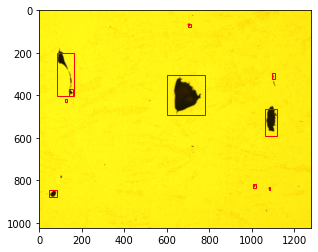

In [6]:
#################################
# Draw bounding boxes
#################################
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from mrcnn.config import Config
from mrcnn.model import MaskRCNN
from matplotlib import pyplot
from matplotlib.patches import Rectangle
 
IMG_PATH = '/content/drive/MyDrive/MQP/Trial/H6_subset/A1H6COL_22.tif'
WEIGHTS_PATH = 'custom_mrcnn_coco.h5'

# draw an image with detected objects
def draw_image_with_boxes(filename, boxes_list):
     # load the image
     data = pyplot.imread(filename)
     # plot the image
     pyplot.imshow(data)
     # get the context for drawing boxes
     ax = pyplot.gca()
     # plot each box
     for box in boxes_list:
          # get coordinates
          y1, x1, y2, x2 = box
          # calculate width and height of the box
          width, height = x2 - x1, y2 - y1
          # create the shape
          rect = Rectangle((x1, y1), width, height, fill=False, color='red')
          # draw the box
          ax.add_patch(rect)
     # show the plot
     pyplot.show()
 
# define the test configuration
class TestConfig(Config):
     NAME = "test"
     GPU_COUNT = 1
     IMAGES_PER_GPU = 1
     NUM_CLASSES = 4
 
# define the model
rcnn = MaskRCNN(mode='inference', model_dir='./', config=TestConfig())
# load coco model weights
rcnn.load_weights(WEIGHTS_PATH, by_name=True)
# load photograph
img = load_img(IMG_PATH)
img = img_to_array(img)
# make prediction
results = rcnn.detect([img], verbose=0)
# visualize the results
draw_image_with_boxes(IMG_PATH, results[0]['rois'])